# Project 1 Notebook - Luca Visser

## Introduction

This notebook contains all the necessary code and annotations for the project. It includes data preprocessing, exploratory data analysis, feature selection, model training, and evaluation steps. For a comprehensive view and access to all the data and code used in this project, please visit my GitHub page: [GitHub Repository](https://github.com/Lucmeister55/MLLS_Project1).

## Raw data Import

The first step in our process is to import all the raw datasets that we have at our disposal.

### Test Dataset

Initially, the test set data was procured from the Kaggle competition page (https://www.kaggle.com/competitions/bicycle-counter-prediction/data). This dataset, which represents approximately 48% of the full test set, is aggregated on an hourly basis. Despite its reduced size, the test set covers the entire month of July 2023. The dimensions of the test set, its time range, and a preview of the initial few rows are displayed below.

In [122]:
# Import necessary libraries
import pandas as pd
import numpy as np
import datetime

# Load the test data from a CSV file
test_rawdata = pd.read_csv("input/test_data.csv")

# Print the shape of the data (number of rows, number of columns)
print(test_rawdata.shape)

# Print the earliest date in the "Date_hour" column
print(min(test_rawdata["Date_hour"]))

# Print the latest date in the "Date_hour" column
print(max(test_rawdata["Date_hour"]))

# Display the first 5 rows of the data
test_rawdata.head()

(744, 2)
2023-07-01T00
2023-07-31T23


,Id,Date_hour
0,0,2023-07-01T00
1,1,2023-07-01T01
2,2,2023-07-01T02
3,3,2023-07-01T03
4,4,2023-07-01T04


### Bycicle measurements

Bicycle count data from various locations was obtained from the Ghent Open Data Portal (https://data.stad.gent/explore/?disjunctive.keyword&disjunctive.theme&sort=modified). The most relevant datasets, specifically those with a duration of more than two years, were selected for further analysis. These datasets, which represent the cumulative count of cyclists passing every five minutes, were saved yearly in the subsequent code chunk.

In [123]:
# Read in data for Coupure Links for the years 2021, 2022, and 2023
coupurelinks_2021 = pd.read_csv("input/fietstelpaal-coupure-links-2021-gent.csv", sep = ";")
coupurelinks_2022 = pd.read_csv("input/fietstelpaal-coupure-links-2022-gent.csv", sep = ";")
coupurelinks_2023 = pd.read_csv("input/fietstelpaal-coupure-links-2023-gent.csv", sep = ";")

# Read in data for Groendreef for the years 2021, 2022, and 2023
groendreef_2021 = pd.read_csv("input/fietstelpaal-groendreef-2021-gent.csv", sep = ";")
groendreef_2022 = pd.read_csv("input/fietstelpaal-groendreef-2022-gent.csv", sep = ";")
groendreef_2023 = pd.read_csv("input/fietstelpaal-groendreef-2023-gent.csv", sep = ";")

The following step involves merging the yearly datasets for each location into a single comprehensive dataframe. This process allows for a more streamlined analysis of the data over multiple years. Please note that the time ranges for each dataset are also displayed for reference.

In [124]:
# Concatenate the data for Coupure Links for the years 2021, 2022, and 2023
coupurelinks = pd.concat([coupurelinks_2021, coupurelinks_2022, coupurelinks_2023])

# Create a copy of the concatenated data
bicycle_data = coupurelinks.copy()

# Rename the "Totaal" column to "Totaal_CL"
coupurelinks = coupurelinks.rename(columns = {"Totaal": "Totaal_CL"})

# Print the earliest and latest dates in the "Datum" column for Coupure Links
print("CL")
print(min(coupurelinks["Datum"]))
print(max(coupurelinks["Datum"]))

# Concatenate the data for Groendreef for the years 2021, 2022, and 2023
groendreef = pd.concat([groendreef_2021, groendreef_2022, groendreef_2023])

# Rename the "Totaal" column to "Totaal_GD"
groendreef = groendreef.rename(columns = {"Totaal": "Totaal_GD"})

# Print the earliest and latest dates in the "Datum" column for Groendreef
print("GD")
print(min(groendreef["Datum"]))
print(max(groendreef["Datum"]))

CL
2021-03-01
2023-07-31
GD
2021-01-01
2023-07-31


Unfortunately, it seems that certain count measurements are missing from the bicycle counter dataset downloaded. This is also mentioned in the corresponding browser overview page of the database portal. Preprocessing of this data will thus be in order.

In [125]:
# Print the number of missing values in each column of the bicycle_data DataFrame
print(bicycle_data.isna().sum())

Code               0
Locatie             0
Datum               0
Uur5Minuten         0
Ordening            0
Totaal           4032
Tegenrichting    4032
Hoofdrichting    4032
dtype: int64


### Weather

Weather conditions play a pivotal role in influencing an individual's decision to cycle, making it a crucial factor in our predictive model. The weather data used in this analysis was sourced from Open Meteo (https://open-meteo.com/en/docs/historical-weather-api#latitude=51.05&longitude=3.7167). The features we selected for this study include objective and apparent temperature (measured in degrees Celsius), precipitation (recorded in millimeters for both rain and snow), cloud cover at all altitudes, and a boolean variable indicating day or nighttime.

Out of the 33,576 rows in this dataset, 24 contain missing values. Given the negligible fraction of missing data, we decided to remove these rows instead of imputing them.

- **Objective temperature (float)**: This feature represents the ambient temperature, excluding the effects of wind and other environmental factors.
- **Apparent temperature (float)**: This is the temperature as perceived by humans, taking into account all environmental effects such as wind and humidity.
- **Precipitation (float)**: High levels of rainfall or snow accumulation can deter individuals from cycling due to discomfort or safety concerns. This feature captures the total precipitation in millimeters.
- **Cloud cover (float)**: This feature represents the fraction of the sky obscured by clouds at all altitudes. It is associated with weather conditions like rain, storms, and temperature, and can significantly impact the cycling experience.
- **Day boolean (log)**: This boolean variable indicates whether it's day or night. Generally, cycling conditions are better during the day, which also aligns with societal "active" hours.

While weather conditions significantly influence cycling patterns, it's important to note that they alone may not be sufficient to accurately predict the number of cyclists at a given time. For instance, while colder temperatures might deter cycling, this isn't a linear or independent relationship. Warmer temperatures are more prevalent during summer, a period when cycling activity may decrease due to holidays (given that students and working individuals constitute a large portion of cyclists). Therefore, additional features are necessary to capture these seasonal variations.

In addition to weather data, other factors such as local events, public holidays, school schedules, and traffic conditions can also influence cycling patterns. By incorporating these additional features into our model, we can better capture the complex interplay of factors that influence an individual's decision to cycle, thereby improving the accuracy of our predictions.

In [126]:
# Read in weather data from a CSV file, skipping the first 2 rows and dropping any rows with missing values
weather_rawdata = pd.read_csv("input/open-meteo-51.07N3.71E13m.csv", skiprows=2).dropna()

# Print the shape of the weather data (number of rows, number of columns)
print(weather_rawdata.shape)

# Display the first 5 rows of the weather data
weather_rawdata.head()

(33576, 9)


,time,temperature_2m (°C),apparent_temperature (°C),precipitation (mm),cloud_cover (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%),is_day ()
0,2020-01-01T00:00,3.3,-0.1,0.0,44.0,49.0,0.0,0.0,0
1,2020-01-01T01:00,2.8,-0.6,0.0,17.0,19.0,0.0,0.0,0
2,2020-01-01T02:00,2.5,-1.0,0.0,10.0,11.0,0.0,0.0,0
3,2020-01-01T03:00,1.9,-1.6,0.0,3.0,3.0,0.0,0.0,0
4,2020-01-01T04:00,1.4,-2.2,0.0,0.0,0.0,0.0,0.0,0


### School Holidays

School holidays in primary and secondary academic institutions can significantly impact the number of cyclists in the region. This is particularly true for areas near schools, where cycling is a common mode of transportation for students and their parents. 

For instance, there's a school located just across the river from the bicycle counter at Coupure Links. On a typical school day, this area would see a high volume of cycling traffic as students and parents commute to and from school. However, during school holidays, this pattern changes. 

With no school sessions, the need for students and their parents to commute reduces drastically. As a result, we can expect a noticeable decrease in cycling traffic at this location during these periods. This pattern is not just limited to the immediate vicinity of the school. The ripple effect of school holidays could potentially influence cycling patterns in the broader region as well.

Therefore, when predicting bicycle counts, it's crucial to take into account the school calendar. By doing so, we can make more accurate predictions that reflect the real-world fluctuations in cycling activity.

In [127]:
# Read in school holidays data from a CSV file
school_holidays_data = pd.read_csv("input/school_holidays.csv", sep = ";")

# Import the datetime module
import datetime

# Initialize an empty dictionary to store the school holidays data
school_holidays = {}

# Loop over each row in the school holidays data
for index, row in school_holidays_data.iterrows():
    # For each row, add an entry to the dictionary with the name of the holiday as the key and the start and end dates as the value
    school_holidays[row['name']] = [datetime.datetime.strptime(row['start'], '%Y-%m-%d'), datetime.datetime.strptime(row['end'], '%Y-%m-%d')]

# Print the school holidays dictionary
print(school_holidays)

{'Christmas holiday 2020': [datetime.datetime(2020, 12, 21, 0, 0), datetime.datetime(2021, 1, 3, 0, 0)], 'Spring break 2021': [datetime.datetime(2021, 2, 15, 0, 0), datetime.datetime(2021, 2, 21, 0, 0)], 'Easter holiday 2021': [datetime.datetime(2021, 4, 5, 0, 0), datetime.datetime(2021, 4, 18, 0, 0)], 'Summer holiday 2021': [datetime.datetime(2021, 7, 1, 0, 0), datetime.datetime(2021, 8, 31, 0, 0)], 'Autumn break 2021': [datetime.datetime(2021, 11, 1, 0, 0), datetime.datetime(2021, 11, 7, 0, 0)], 'Christmas holiday 2021': [datetime.datetime(2021, 12, 27, 0, 0), datetime.datetime(2022, 1, 9, 0, 0)], 'Spring break 2022': [datetime.datetime(2022, 2, 28, 0, 0), datetime.datetime(2022, 3, 6, 0, 0)], 'Easter holiday 2022': [datetime.datetime(2022, 4, 4, 0, 0), datetime.datetime(2022, 4, 18, 0, 0)], 'Summer holiday 2022': [datetime.datetime(2022, 7, 1, 0, 0), datetime.datetime(2022, 8, 31, 0, 0)], 'Autumn break 2022': [datetime.datetime(2022, 10, 31, 0, 0), datetime.datetime(2022, 11, 6, 0, 

### Public holidays

Cycling is a common mode of transportation for many individuals commuting to work. On public holidays, however, we can anticipate a significant reduction in this type of cycling traffic. This is because many workplaces are closed on these days, eliminating the need for employees to commute. Therefore, the count of cyclists recorded on public holidays is likely to be lower compared to regular working days. This factor is important to consider when predicting bicycle counts.

In [128]:
# Import the holidays library
import holidays

# Get a list of Belgian holidays for the years 2021, 2022, and 2023
belgian_holidays = holidays.Belgium(years=[2021, 2022, 2023])

# Print the list of Belgian holidays
print(belgian_holidays)

{datetime.date(2021, 1, 1): 'Nieuwjaar', datetime.date(2021, 4, 4): 'Pasen', datetime.date(2021, 4, 5): 'Paasmaandag', datetime.date(2021, 5, 1): 'Dag van de Arbeid', datetime.date(2021, 5, 13): 'O. L. H. Hemelvaart', datetime.date(2021, 5, 23): 'Pinksteren', datetime.date(2021, 5, 24): 'Pinkstermaandag', datetime.date(2021, 7, 21): 'Nationale feestdag', datetime.date(2021, 8, 15): 'O. L. V. Hemelvaart', datetime.date(2021, 11, 1): 'Allerheiligen', datetime.date(2021, 11, 11): 'Wapenstilstand', datetime.date(2021, 12, 25): 'Kerstmis', datetime.date(2022, 1, 1): 'Nieuwjaar', datetime.date(2022, 4, 17): 'Pasen', datetime.date(2022, 4, 18): 'Paasmaandag', datetime.date(2022, 5, 1): 'Dag van de Arbeid', datetime.date(2022, 5, 26): 'O. L. H. Hemelvaart', datetime.date(2022, 6, 5): 'Pinksteren', datetime.date(2022, 6, 6): 'Pinkstermaandag', datetime.date(2022, 7, 21): 'Nationale feestdag', datetime.date(2022, 8, 15): 'O. L. V. Hemelvaart', datetime.date(2022, 11, 1): 'Allerheiligen', datetim

## Mundane data preprocessing

### Bicycle measurements

To address the issue of missing count values in our dataset, we will employ an imputation strategy. Specifically, we will use a simple imputer, a method that replaces missing values with a descriptive statistic calculated for each column. In this case, we will use the mean of each column to replace the missing values. This approach helps maintain the overall distribution of the data while filling in the gaps where data is missing.

However, it's important to note that imputation methods can introduce some level of bias into the data, as they essentially involve making assumptions about the missing values based on the existing data. Therefore, the choice of imputation method should be carefully considered based on the nature of the data and the specific requirements of the analysis.

In addition to imputing missing values, we will also transform the measurements to be summed across every hour. This is to ensure consistency with the test set, which is aggregated on an hourly basis. By aligning the granularity of our training data with that of the test set, we can ensure that our model is trained and evaluated on data with the same structure and scale, thereby improving the reliability of our predictions.

In [129]:
# Import necessary modules for imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# Extract the date and hour from the 'Ordening' column and store it in a new column 'Date_hour'
bicycle_data["Date_hour"] = bicycle_data['Ordening'].str.extract(r'^(.*?T\d{2})..')

# Initialize a SimpleImputer
imputer = SimpleImputer()

# Use the imputer to fill in missing values in the columns that start with 'Totaal'
bicycle_imputed = imputer.fit_transform(bicycle_data.filter(regex='^Totaal', axis=1))

# Replace the original columns with the imputed data, rounding to the nearest integer
bicycle_data[bicycle_data.filter(regex='^Totaal', axis=1).columns] = bicycle_imputed.round().astype(int)

# Group the data by 'Datum' and 'Date_hour', summing the 'Totaal' column, and reset the index
bicycle_data = bicycle_data.groupby(['Datum', 'Date_hour']).agg({'Totaal': 'sum'}).reset_index()

# Print the shape of the data (number of rows, number of columns)
print(bicycle_data.shape)

# Print the earliest and latest dates in the 'Date_hour' column
print(min(bicycle_data["Date_hour"]))
print(max(bicycle_data["Date_hour"]))

# Display the first 5 rows of the data
bicycle_data.head()

(21189, 3)
2021-03-01T00
2023-07-31T23


,Datum,Date_hour,Totaal
0,2021-03-01,2021-03-01T00,5
1,2021-03-01,2021-03-01T01,1
2,2021-03-01,2021-03-01T02,0
3,2021-03-01,2021-03-01T03,2
4,2021-03-01,2021-03-01T04,21


As we can see, there are no longer any missing values present in the dataset after imputation.

In [130]:
# Print the number of missing values in each column of the bicycle_data DataFrame
print(bicycle_data.isna().sum())

Datum        0
Date_hour    0
Totaal       0
dtype: int64


To address the issue of autocorrelation in our dataset, we will incorporate a transformed Coupure Links response ("Totaal") column as a feature. This feature will be lagged by one year relative to the time point indexation. Autocorrelation refers to the correlation of a time series with a lagged version of itself. By including a lagged feature in our model, we can capture the temporal dependencies in our data, which is a common approach in time-series analysis.

However, this approach introduces many additional missing values in our dataset. This is because for the initial period of our dataset (e.g., 2021), there is no corresponding lagged data from the previous year. Therefore, we will need to perform imputation on both the raw Coupure Links dataset and the newly created lagged feature.

It's important to note that while dealing with autocorrelation is a common practice in time-series analysis, it's not strictly necessary in this case. However, our preliminary analysis suggests that including a lagged feature improves the performance of our model on the test set.

In time-series analysis, it's crucial to consider the temporal dependencies in the data. By incorporating a lagged feature in our model, we are able to capture the influence of past observations on the current observation. This can provide our model with valuable information that can enhance its predictive power. However, this approach should be used with caution, as it can introduce additional complexity into our model and may lead to overfitting if not properly managed.

In [131]:
# Extract the date and hour from the 'Ordening' column and store it in a new column 'Date_hour'
coupurelinks["Date_hour"] = coupurelinks['Ordening'].str.extract(r'^(.*?T\d{2})..')

# Use the imputer to fill in missing values in the columns that start with 'Totaal'
coupurelinks_imputed = imputer.fit_transform(coupurelinks.filter(regex='^Totaal', axis=1))

# Replace the original columns with the imputed data, rounding to the nearest integer
coupurelinks[coupurelinks.filter(regex='^Totaal', axis=1).columns] = coupurelinks_imputed.round().astype(int)

# Group the data by 'Datum' and 'Date_hour', summing the 'Totaal_CL' column, and reset the index
coupurelinks = coupurelinks.groupby(['Datum', 'Date_hour']).agg({'Totaal_CL': "sum"}).reset_index()

# Set the index of the DataFrame to be the 'Date_hour' column
coupurelinks = coupurelinks.set_index(pd.DatetimeIndex(coupurelinks['Date_hour']))

# Create a new column 'LaggedTotaal_CL_year' that is the 'Totaal_CL' column shifted by one year
coupurelinks['LaggedTotaal_CL_year'] = coupurelinks['Totaal_CL'].shift(freq=pd.DateOffset(years=1))

# Reset the index of the DataFrame
coupurelinks = coupurelinks.reset_index(drop = True)

# Display the first 5 rows of the DataFrame
coupurelinks.head()

,Datum,Date_hour,Totaal_CL,LaggedTotaal_CL_year
0,2021-03-01,2021-03-01T00,5,NaN
1,2021-03-01,2021-03-01T01,1,NaN
2,2021-03-01,2021-03-01T02,0,NaN
3,2021-03-01,2021-03-01T03,2,NaN
4,2021-03-01,2021-03-01T04,21,NaN


Now we'll do the exact same for our other bike counters:

In [132]:
# Groendreef

# Extract the date and hour from the 'Ordening' column and store it in a new column 'Date_hour'
groendreef["Date_hour"] = groendreef['Ordening'].str.extract(r'^(.*?T\d{2})..')

# Use the imputer to fill in missing values in the columns that start with 'Totaal'
groendreef_imputed = imputer.fit_transform(groendreef.filter(regex='^Totaal', axis=1))

# Replace the original columns with the imputed data, rounding to the nearest integer
groendreef[groendreef.filter(regex='^Totaal', axis=1).columns] = groendreef_imputed.round().astype(int)

# Group the data by 'Datum' and 'Date_hour', summing the 'Totaal_GD' column, and reset the index
groendreef = groendreef.groupby(['Datum', 'Date_hour']).agg({'Totaal_GD': "sum"}).reset_index()

# Set the index of the DataFrame to be the 'Date_hour' column
groendreef = groendreef.set_index(pd.DatetimeIndex(groendreef['Date_hour']))

# Create a new column 'LaggedTotaal_GD_year' that is the 'Totaal_GD' column shifted by one year
groendreef['LaggedTotaal_GD_year'] = groendreef['Totaal_GD'].shift(freq=pd.DateOffset(years=1))

# Reset the index of the DataFrame
groendreef = groendreef.reset_index(drop = True)

# Display the first 5 rows of the DataFrame
groendreef.head()

,Datum,Date_hour,Totaal_GD,LaggedTotaal_GD_year
0,2021-01-01,2021-01-01T00,5,NaN
1,2021-01-01,2021-01-01T01,0,NaN
2,2021-01-01,2021-01-01T02,1,NaN
3,2021-01-01,2021-01-01T03,0,NaN
4,2021-01-01,2021-01-01T04,2,NaN


In this code snippet, the lagged features are merged with the main Coupure Links bicycle DataFrame.

In [133]:
# Merge the 'LaggedTotaal_CL_year' column from the coupurelinks DataFrame into the bicycle_data DataFrame, matching on 'Date_hour'
bicycle_data = bicycle_data.merge(coupurelinks.loc[:, ["Date_hour", 'LaggedTotaal_CL_year']], how = "inner", on = "Date_hour")

# Merge the 'LaggedTotaal_GD_year' column from the groendreef DataFrame into the bicycle_data DataFrame, matching on 'Date_hour'
bicycle_data = bicycle_data.merge(groendreef.loc[:, ["Date_hour", 'LaggedTotaal_GD_year']], how = "inner", on = "Date_hour")

# Print the number of missing values in each column of the bicycle_data DataFrame
print(bicycle_data.isna().sum())

# Display the first 5 rows of the bicycle_data DataFrame
bicycle_data.head()

Datum                      0
Date_hour                  0
Totaal                     0
LaggedTotaal_CL_year    8761
LaggedTotaal_GD_year    7345
dtype: int64


,Datum,Date_hour,Totaal,LaggedTotaal_CL_year,LaggedTotaal_GD_year
0,2021-03-01,2021-03-01T00,5,NaN,NaN
1,2021-03-01,2021-03-01T01,1,NaN,NaN
2,2021-03-01,2021-03-01T02,0,NaN,NaN
3,2021-03-01,2021-03-01T03,2,NaN,NaN
4,2021-03-01,2021-03-01T04,21,NaN,NaN


While these aforementioned missing values could potentially be a concern, we have a strategy to address this issue. One approach would be to reduce the number of rows in our dataset to align exactly with the range of the lagged features. This would effectively eliminate the rows with missing values in the lagged features.

However, we will not implement this solution immediately. Instead, we will first impute these missing values. This step is crucial as some of the missing values may fall within the range of data that we intend to use for our analysis. By imputing these values, we ensure that we do not inadvertently exclude potentially useful data from our analysis.

In [134]:
# Use the imputer to fill in missing values in the columns that start with 'Lagged'
bicycle_imputed = imputer.fit_transform(bicycle_data.filter(regex='^Lagged', axis=1))

# Replace the original columns with the imputed data, rounding to the nearest integer
bicycle_data[bicycle_data.filter(regex='^Lagged', axis=1).columns] = bicycle_imputed.round().astype(int)

# Display the first 5 rows of the bicycle_data DataFrame
bicycle_data.head()

,Datum,Date_hour,Totaal,LaggedTotaal_CL_year,LaggedTotaal_GD_year
0,2021-03-01,2021-03-01T00,5,274,179
1,2021-03-01,2021-03-01T01,1,274,179
2,2021-03-01,2021-03-01T02,0,274,179
3,2021-03-01,2021-03-01T03,2,274,179
4,2021-03-01,2021-03-01T04,21,274,179


Lo and behold, no more missing values.

In [135]:
# Print the number of missing values in each column of the bicycle_data DataFrame
print(bicycle_data.isna().sum())

Datum                   0
Date_hour               0
Totaal                  0
LaggedTotaal_CL_year    0
LaggedTotaal_GD_year    0
dtype: int64


### Features

In this section, we're enhancing our dataset by adding and transforming several time-related columns. These modifications will be beneficial when we start the feature engineering process.

While these newly added columns won't be used directly as features in our model, they will serve as the basis for creating more complex features during the feature engineering stage. For instance, we could use these columns to create features that capture the interaction between different aspects of time (e.g., the effect of weekends versus weekdays at different times of the day).

By enriching our dataset with these time-related columns, we're setting the stage for a more comprehensive and nuanced analysis of our data. This will ultimately help us build a more accurate and robust predictive model.

In [136]:
# Import the timedelta function from the datetime module
from datetime import timedelta

# Create a copy of the weather_rawdata DataFrame
weather_data = weather_rawdata.copy()

# Split the column names on spaces and keep only the first part
weather_data.columns = weather_data.columns.str.split(' ').str[0]

# Extract the date and hour from the 'time' column and store it in a new column 'Date_hour'
weather_data["Date_hour"] = weather_data["time"].str.split(':', expand = True)[0]

# Drop the 'time' column from the DataFrame
weather_data = weather_data.drop("time", axis = 1)

# Filter the DataFrame to only include rows where 'Date_hour' is between the minimum 'Date_hour' in bicycle_data and the maximum 'Date_hour' in test_rawdata
weather_data = weather_data[(min(bicycle_data["Date_hour"]) <= weather_data['Date_hour']) & (weather_data['Date_hour'] <= max(test_rawdata["Date_hour"]))]

# Convert the 'Date_hour' column to datetime format
date_time = pd.to_datetime(weather_data['Date_hour'])

# Create new columns for the date, year, month, and day
weather_data["date_dt"] = date_time.dt.date
weather_data["date"] = date_time.dt.strftime("%Y-%m-%d")
weather_data["month_day"] = date_time.dt.strftime("%m-%d")
weather_data["year"] = date_time.dt.strftime("%Y")
weather_data["month_year"] = date_time.dt.strftime("%m-%Y")

# Create new columns for the next and previous day
weather_data['next_day'] = date_time + timedelta(days=1)
weather_data['prev_day'] = date_time - timedelta(days=1)

# Print the shape of the data (number of rows, number of columns)
print(weather_data.shape)

# Print the earliest and latest dates in the 'Date_hour' column
print(min(weather_data["Date_hour"]))
print(max(weather_data["Date_hour"]))

# Display the first 5 rows of the data
weather_data.head()

(21192, 16)
2021-03-01T00
2023-07-31T23


,temperature_2m,apparent_temperature,precipitation,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,is_day,Date_hour,date_dt,date,month_day,year,month_year,next_day,prev_day
10200,4.0,0.9,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T00,2021-03-01,2021-03-01,03-01,2021,03-2021,2021-03-02 00:00:00,2021-02-28 00:00:00
10201,3.6,0.5,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T01,2021-03-01,2021-03-01,03-01,2021,03-2021,2021-03-02 01:00:00,2021-02-28 01:00:00
10202,3.2,0.1,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T02,2021-03-01,2021-03-01,03-01,2021,03-2021,2021-03-02 02:00:00,2021-02-28 02:00:00
10203,2.9,-0.4,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T03,2021-03-01,2021-03-01,03-01,2021,03-2021,2021-03-02 03:00:00,2021-02-28 03:00:00
10204,2.6,-0.8,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T04,2021-03-01,2021-03-01,03-01,2021,03-2021,2021-03-02 04:00:00,2021-02-28 04:00:00


### Feature engineering

In this section, we're enhancing our dataset by engineering new features from the raw data available to us. The goal of feature engineering is to provide more meaningful input to our model, thereby improving its predictive performance.

The features we're creating in this chunk are primarily time-related, capturing various aspects of the temporal patterns in our data. These features include:

- **Day of the week (str)**: This feature captures the specific day of the week for each observation. The rationale behind this feature is that certain days of the week may exhibit higher cycling activity. For instance, Mondays might see an increase in cycling traffic as people return to work or school after the weekend.

- **Hour of the day (int) + sine & cosine transform (float)**: This feature represents the specific hour of the day for each observation. The cycling activity is likely to vary throughout the day, with more people cycling during daylight hours and at the start of the workday compared to nighttime or lunchtime. To capture the cyclic nature of the hours of the day, we also add the sine and cosine of the hour as features, with a period of 24 hours. This transformation helps our model understand that the hours of the day are a cyclical feature, with hour 23 being as close to hour 0 as to hour 22.

- **Month of the year (int & str)**: This feature indicates the specific month of the year for each observation. The assumption here is that cycling activity may vary by month. For example, the summer months might see less cycling activity due to holidays, festivals, or leaves of absence.

- **Season (str)**: This feature categorizes each observation into one of the four seasons: spring, summer, autumn, or winter. The reasoning behind this feature is similar to that of the month of the year, but it provides a less granular view. The idea is that cycling activity may vary by season, with certain seasons potentially seeing more cycling activity due to favorable weather conditions.

In [137]:
# Import the calendar module
import calendar

# Create a copy of the weather_data DataFrame
feature_data = weather_data.copy()

# Create a new column 'weekday' that contains the day of the week for each date
feature_data['weekday'] = date_time.dt.strftime('%A')

# Create a new column 'hour' that contains the hour for each date
feature_data['hour'] = date_time.dt.hour

# Create a new column 'hour_sin' that contains the sine of the hour (for circular encoding)
feature_data['hour_sin'] = np.sin(2 * np.pi * (feature_data['hour']) / 24)

# Create a new column 'hour_cosin' that contains the cosine of the hour (for circular encoding)
feature_data['hour_cosin'] = np.cos(2 * np.pi * (feature_data['hour']) / 24)

# Create a new column 'month' that contains the month for each date
feature_data["month"] = date_time.dt.month

# Create a new column 'month_name' that contains the name of the month for each date
feature_data['month_name'] = feature_data['month'].apply(lambda x: calendar.month_name[x])

# Define a function to get the season based on the month
def get_season(date):
    month = date.month
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Fall'
    else:
        return 'Winter'

# Create a new column 'season' that contains the season for each date
feature_data['season'] = feature_data['date_dt'].apply(get_season)

In this section, we're further enhancing our dataset by adding several boolean features. These features are designed to capture specific patterns in our data that are likely to influence cycling activity. 

- **Weekday boolean (log)**: This feature indicates whether a given day is a weekday. The assumption here is that cycling activity will be higher during weekdays as people commute to work or school.

- **School hours boolean (log)**: This feature indicates whether a given time falls within school or working hours, roughly between 8 AM and 5 PM. The hypothesis is that cycling activity will be higher during these hours as people are more likely to be active and commuting.

- **University lessons boolean (log)**: Given the proximity of the Coupure Links bike counter to the Bio-Engineering campus and the high population of students in Ghent, we expect cycling activity to increase during university lesson periods and decrease during academic holidays and exam periods. While it would be ideal to include more granular information about university activity, such as specific study breaks or exam periods, this would require extensive manual curation. Therefore, due to time constraints, we've chosen to focus on the most significant aspect, which is the lesson periods.

- **Ghent event boolean (log)**: This feature indicates the occurrence of major festivals in Ghent. Such events are likely to impact cycling activity due to factors such as people taking time off work, roadblocks obstructing cyclists, and increased tourist activity. This feature is particularly relevant for our test set, as it includes the period of the Gentse Feesten, the largest event in Ghent, which takes place towards the end of July. For the sake of time, only the most important is included for July is included for now (Gentse Feesten). Ideally, we would add all festivals of varying importance, including the Ghent Light Festival, Ghent Jazz Festival, Christmas market, and so on.

In [138]:
# Define a function to check if a date falls within any interval
def date_in_intervals(dates, intervals):
    result = [0] * len(dates)  # Initialize the result list with 0s
    
    for i, date in enumerate(dates):
        for interval in intervals.values():
            start, end = interval[0], interval[1]
            if start <= date <= end:
                result[i] = 1
                break
    
    return result

# Define the dates of university lessons
university_lessons = {
    "sem1": ["09-26", "12-19"],
    "sem2_1": ["02-13", "04-02"],
    "sem2_2": ["04-17", "05-06"]
}

# Define the dates of the Ghent event
Ghent_event = {"gentsefeesten": ['07-14', '07-23']}

# Create a new column 'is_weekday' that is 1 if the day is a weekday and 0 otherwise
feature_data['is_weekday'] = (~feature_data['weekday'].isin(["Saturday", "Sunday"])).astype(int)

# Create a new column 'is_school_hours' that is 1 if the hour is between 8 and 17 and 0 otherwise
feature_data['is_school_hours'] = ((date_time.dt.hour >= 8) & (date_time.dt.hour <= 17)).astype(int)

# Create a new column 'is_university_lessons' that is 1 if the date is during university lessons and 0 otherwise
feature_data['is_university_lessons'] = date_in_intervals(feature_data["month_day"], university_lessons)

# Create a new column 'is_Ghent_event' that is 1 if the date is during the Ghent event and 0 otherwise
feature_data['is_Ghent_event'] = date_in_intervals(feature_data["month_day"], Ghent_event)

- **Public holiday boolean (log)**: This feature indicates whether a given day is a public holiday. The assumption here is that cycling activity will decrease on public holidays as fewer people will be commuting to work. This is particularly relevant in a city like Ghent, where a significant portion of the population is likely to be employed and thus affected by public holidays.

- **Bridge day boolean (log)**: This feature identifies the days that fall between a weekend and a public holiday, often referred to as "bridge days". On these days, many people choose to take a day off from work to extend their holiday period. As a result, we can expect a decrease in cycling activity on bridge days, similar to public holidays.

- **School holiday boolean (log)**: This feature indicates whether a given day falls within a school holiday period. The rationale behind this feature is that cycling activity will decrease during school holidays as fewer students will be commuting. This is especially relevant in a city like Ghent, which has a high student population.

- **Construction holiday boolean (log)**: This feature identifies the period known as the "construction holiday", during which the construction sector pauses all ongoing projects. This period typically occurs during the summer and can have a significant impact on the overall activity in the city. The assumption here is that cycling activity will decrease during the construction holiday due to a reduction in the number of construction workers commuting and a general slowdown in city activity.

In [139]:
# Define the dates of the construction holiday
bouwverlof = {
    "summer": ["07-17", "08-07"],
}

# Create a new column 'is_public_holiday' that is 1 if the date is a public holiday and 0 otherwise
feature_data['is_public_holiday'] = (date_time.dt.date.isin(belgian_holidays)).astype(int)

# Create a new column 'is_bridge_day' that is 1 if the day is a Monday or Friday and the next or previous day is a public holiday, and 0 otherwise
feature_data['is_bridge_day'] = (feature_data['weekday'].isin(["Monday", "Friday"]) & feature_data['next_day'].dt.date.isin(belgian_holidays) | feature_data['prev_day'].dt.date.isin(belgian_holidays)).astype(int)

# Initialize a list to store whether each date is a school holiday
is_school_holiday = [0] * len(date_time)

# For each date, check if it falls within any of the school holiday date ranges
for i, check_date in enumerate(date_time):
    for holiday, date_range in school_holidays.items():
        start_date = date_range[0]
        end_date = date_range[1]
        if start_date <= check_date <= end_date:
            is_school_holiday[i] = 1

# Create a new column 'is_school_holiday' that is 1 if the date is a school holiday and 0 otherwise
feature_data["is_school_holiday"] = is_school_holiday

# Create a new column 'is_bouwverlof' that is 1 if the date is during the construction holiday and 0 otherwise
feature_data['is_bouwverlof'] = date_in_intervals(feature_data["month_day"], bouwverlof)

This is our feature dataset so far. Quite extensive already, but we're not done yet.

In [140]:
# Print the shape of the feature_data DataFrame (number of rows, number of columns)
print(feature_data.shape)

# Display the first 5 rows of the feature_data DataFrame
feature_data.head()

(21192, 31)


,temperature_2m,apparent_temperature,precipitation,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,is_day,Date_hour,date_dt,...,month_name,season,is_weekday,is_school_hours,is_university_lessons,is_Ghent_event,is_public_holiday,is_bridge_day,is_school_holiday,is_bouwverlof
10200,4.0,0.9,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T00,2021-03-01,...,March,Spring,1,0,1,0,0,0,0,0
10201,3.6,0.5,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T01,2021-03-01,...,March,Spring,1,0,1,0,0,0,0,0
10202,3.2,0.1,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T02,2021-03-01,...,March,Spring,1,0,1,0,0,0,0,0
10203,2.9,-0.4,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T03,2021-03-01,...,March,Spring,1,0,1,0,0,0,0,0
10204,2.6,-0.8,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T04,2021-03-01,...,March,Spring,1,0,1,0,0,0,0,0


Several of our features, specifically the day of the week and the season, are currently represented as categorical string variables. While these variables provide valuable information, they are not in a format that can be directly interpreted by most mathematical models. 

To address this, we will transform these categorical variables into a numerical format using a technique known as dummy encoding. Dummy encoding involves creating a new binary (0 or 1) variable for each category of the original variable. For instance, the 'day of the week' feature, which has seven categories (Monday to Sunday), will be transformed into seven new binary features.

This transformation allows us to retain the valuable information contained in these categorical variables in a format that can be readily processed by our model. However, it's important to note that dummy encoding can significantly increase the dimensionality of our dataset, as each category of each categorical variable becomes a new feature. Therefore, it's crucial to use this technique judiciously and ensure that it contributes positively to the performance of our model.

This step is not strictly necessary for certain tree methods, but neither does it do any harm.

In [141]:
# Create dummy variables for the 'weekday' and 'season' columns and concatenate them into a new DataFrame 'dummies'
dummies = pd.concat([pd.get_dummies(feature_data.weekday), pd.get_dummies(feature_data.season)], axis = 1)

# Display the first 5 rows of the 'dummies' DataFrame
dummies.head()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Fall,Spring,Summer,Winter
10200,0,1,0,0,0,0,0,0,1,0,0
10201,0,1,0,0,0,0,0,0,1,0,0
10202,0,1,0,0,0,0,0,0,1,0,0
10203,0,1,0,0,0,0,0,0,1,0,0
10204,0,1,0,0,0,0,0,0,1,0,0


The dummy variables, which we've created to represent categorical data in a format suitable for machine learning algorithms, are then appended to our continuously expanding set of features.

In [142]:
# Concatenate the 'dummies' DataFrame with the 'feature_data' DataFrame
feature_data = pd.concat([feature_data, dummies], axis=1)

# Print the shape of the 'feature_data' DataFrame (number of rows, number of columns)
print(feature_data.shape)

# Display the first 5 rows of the 'feature_data' DataFrame
feature_data.head()

(21192, 42)


,temperature_2m,apparent_temperature,precipitation,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,is_day,Date_hour,date_dt,...,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Fall,Spring,Summer,Winter
10200,4.0,0.9,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T00,2021-03-01,...,1,0,0,0,0,0,0,1,0,0
10201,3.6,0.5,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T01,2021-03-01,...,1,0,0,0,0,0,0,1,0,0
10202,3.2,0.1,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T02,2021-03-01,...,1,0,0,0,0,0,0,1,0,0
10203,2.9,-0.4,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T03,2021-03-01,...,1,0,0,0,0,0,0,1,0,0
10204,2.6,-0.8,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T04,2021-03-01,...,1,0,0,0,0,0,0,1,0,0


In the following section, we're merging our bicycle measurement dataframe with our feature set to create an initial dataset for model training. This is a crucial step in preparing our data for machine learning, as it brings together our target variable (bicycle counts) and the features we've engineered to predict it.

We're careful to exclude any data from July 2023 onwards from our training set. Including this data would be inappropriate, as it falls within the period we're aiming to predict. Training our model on this data would essentially be "cheating", as it would give our model access to information about the future that it wouldn't have in a real-world scenario.

After merging the dataframes, we verify that the latest timepoint in our training set is 2023-06-30T23. This is exactly one hour before July 2023 begins, confirming that we've successfully excluded the future data from our training set.

This process of carefully defining our training and test sets is fundamental to ensuring the validity of our model. It's crucial that our model is trained on past data and tested on future data, as this is the scenario it will encounter when deployed in the real world. By adhering to this principle, we can ensure that our model's performance during testing is a reliable indicator of its future performance.

In [143]:
# Merge the 'feature_data' DataFrame with the 'bicycle_data' DataFrame on the 'Date_hour' column
all_data = feature_data.merge(bicycle_data, on = "Date_hour")

# Filter the 'all_data' DataFrame to only include rows where 'Date_hour' is before the minimum 'Date_hour' in 'test_rawdata' and after 2022-03
train_data = all_data[(all_data["Date_hour"] < min(test_rawdata["Date_hour"])) & (all_data["Date_hour"] > "2022-03")]

# Print the shape of the 'train_data' DataFrame (number of rows, number of columns)
print(train_data.shape)

# Print the earliest and latest dates in the 'Date_hour' column of the 'train_data' DataFrame
print(min(train_data["Date_hour"]))
print(max(train_data["Date_hour"]))

# Display the first 5 rows of the 'train_data' DataFrame
train_data.head()

(11686, 46)
2022-03-01T00
2023-06-30T23


,temperature_2m,apparent_temperature,precipitation,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,is_day,Date_hour,date_dt,...,Tuesday,Wednesday,Fall,Spring,Summer,Winter,Datum,Totaal,LaggedTotaal_CL_year,LaggedTotaal_GD_year
8759,3.2,-0.6,0.0,31.0,0.0,1.0,100.0,0,2022-03-01T00,2022-03-01,...,1,0,0,1,0,0,2022-03-01,73,5,2
8760,3.3,-0.4,0.0,51.0,7.0,25.0,100.0,0,2022-03-01T01,2022-03-01,...,1,0,0,1,0,0,2022-03-01,35,1,1
8761,3.5,-0.2,0.0,100.0,55.0,91.0,100.0,0,2022-03-01T02,2022-03-01,...,1,0,0,1,0,0,2022-03-01,44,0,0
8762,3.4,-0.4,0.0,100.0,98.0,100.0,99.0,0,2022-03-01T03,2022-03-01,...,1,0,0,1,0,0,2022-03-01,25,2,1
8763,3.3,-0.3,0.0,100.0,99.0,95.0,100.0,0,2022-03-01T04,2022-03-01,...,1,0,0,1,0,0,2022-03-01,19,21,4


The following performs the same merging action, but then for the test set:

In [144]:
# Merge the 'test_rawdata' DataFrame with the 'feature_data' DataFrame on the 'Date_hour' column
test_data = test_rawdata.merge(feature_data, on = "Date_hour", how = 'left')

# Merge the resulting DataFrame with the 'bicycle_data' DataFrame on the 'Date_hour' column and drop the 'Totaal' column
test_data = test_data.merge(bicycle_data, on = "Date_hour", how = 'left').drop("Totaal", axis = 1)

# Print the shape of the 'test_data' DataFrame (number of rows, number of columns)
print(test_data.shape)

# Print the earliest and latest dates in the 'Date_hour' column of the 'test_data' DataFrame
print(min(test_data["Date_hour"]))
print(max(test_data["Date_hour"]))

# Display the first 5 rows of the 'test_data' DataFrame
test_data.head()

(744, 46)
2023-07-01T00
2023-07-31T23


,Id,Date_hour,temperature_2m,apparent_temperature,precipitation,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,is_day,...,Thursday,Tuesday,Wednesday,Fall,Spring,Summer,Winter,Datum,LaggedTotaal_CL_year,LaggedTotaal_GD_year
0,0,2023-07-01T00,18.0,15.7,0.0,100.0,100.0,99.0,58.0,0,...,0,0,0,0,0,1,0,2023-07-01,96,71
1,1,2023-07-01T01,17.7,15.3,0.0,100.0,100.0,100.0,62.0,0,...,0,0,0,0,0,1,0,2023-07-01,41,42
2,2,2023-07-01T02,17.4,15.0,0.0,100.0,100.0,100.0,85.0,0,...,0,0,0,0,0,1,0,2023-07-01,17,24
3,3,2023-07-01T03,17.2,15.0,0.0,100.0,100.0,85.0,90.0,0,...,0,0,0,0,0,1,0,2023-07-01,49,31
4,4,2023-07-01T04,17.1,15.3,0.0,100.0,100.0,64.0,85.0,1,...,0,0,0,0,0,1,0,2023-07-01,37,31


In typical predictive modeling scenarios, we don't have access to the actual values of the data points we're trying to predict. However, in this particular case, we do have access to the true values for the period we're forecasting, which is July 2023. 

This data, often referred to as the "gold standard", represents the actual outcomes that our model will attempt to predict. Having this data available provides us with a unique opportunity to evaluate the performance of our model in a more concrete and meaningful way. 

Instead of relying solely on statistical measures of model performance, we can compare our model's predictions directly with the true outcomes. This allows us to assess how well our model is able to capture the actual trends and patterns in the data, and provides a more intuitive understanding of its predictive capabilities.

In this context, we will save the gold standard data for July 2023 for later comparison with our model's predictions. This data essentially represents 100% of the true test set, providing a complete picture of the actual outcomes for the period we're forecasting.

In [145]:
# Merge the 'test_rawdata' DataFrame with the 'Totaal' and 'Date_hour' columns of the 'bicycle_data' DataFrame on the 'Date_hour' column
gtest_data = test_rawdata.merge(bicycle_data[["Totaal", "Date_hour"]], on = "Date_hour", how = 'left')

# Print the shape of the 'gtest_data' DataFrame (number of rows, number of columns)
print(gtest_data.shape)

# Print the earliest and latest dates in the 'Date_hour' column of the 'gtest_data' DataFrame
print(min(gtest_data["Date_hour"]))
print(max(gtest_data["Date_hour"]))

# Display the first 5 rows of the 'gtest_data' DataFrame
gtest_data.head()

(744, 3)
2023-07-01T00
2023-07-31T23


,Id,Date_hour,Totaal
0,0,2023-07-01T00,150
1,1,2023-07-01T01,92
2,2,2023-07-01T02,49
3,3,2023-07-01T03,36
4,4,2023-07-01T04,57


As we conclude this section, it's important to identify the "usable" features in our dataset. These are the features that will be used to train and test our predictive model. 

In this context, "usable" features are defined as those that are numerical vectors. This is because most machine learning algorithms can only process numerical data. They cannot handle string or datetime objects directly. Therefore, we need to exclude these non-numerical features from our dataset before we proceed with model training and testing.

However, it's important to note that this doesn't mean that non-numerical data is not useful. On the contrary, string and datetime objects often contain valuable information that can enhance our model's predictive performance. But to utilize this information, we need to transform these non-numerical features into a numerical format, a process known as feature encoding.

In this case, we've already performed this encoding process for several of our features, transforming categorical string variables into numerical format using dummy encoding. Therefore, the remaining string and datetime objects in our dataset are those that we've deemed not useful for our model, and these will be excluded.

By defining our "usable" features in this way, we ensure that our model is trained on relevant, informative data, which is crucial for achieving good predictive performance.

In [146]:
# Get a list of all numeric features in 'train_data' and store it in 'all_features'
all_features = list(train_data.select_dtypes(include='number').columns)

# Define a list of features to remove
elements_to_remove = ["Totaal"]

# Remove the features in 'elements_to_remove' from 'all_features'
all_features = [feature for feature in all_features if feature not in elements_to_remove]

print(all_features)

['temperature_2m', 'apparent_temperature', 'precipitation', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high', 'is_day', 'hour', 'hour_sin', 'hour_cosin', 'month', 'is_weekday', 'is_school_hours', 'is_university_lessons', 'is_Ghent_event', 'is_public_holiday', 'is_bridge_day', 'is_school_holiday', 'is_bouwverlof', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'Fall', 'Spring', 'Summer', 'Winter', 'LaggedTotaal_CL_year', 'LaggedTotaal_GD_year']


## Advanced preprocessing and setup

### Load packages

All packages necessary for the remainder of the pipeline are loaded in this chunk.

In [147]:
# Import the matplotlib.pyplot module for creating static, animated, and interactive visualizations
import matplotlib.pyplot as plt

# Import the seaborn module for statistical data visualization
import seaborn as sns

# Import various modules from sklearn for machine learning tasks
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, Normalizer
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

# Import the XGBRegressor class from the xgboost module for XGBoost regression
from xgboost import XGBRegressor

### Functions

In this section, we're defining a set of helper functions that will be instrumental in our subsequent data analysis and modeling tasks. 

Helper functions are custom functions that we create to perform specific tasks that are not readily available in the libraries we're using, or to simplify complex tasks into single function calls. These functions help to keep our code organized, reusable, and easy to understand.

#### Nested K-fold Cross-Validation

This function is designed to perform nested k-fold cross-validation, a robust method for estimating the performance of machine learning models and optimizing their hyperparameters. 

Nested k-fold cross-validation is essentially a combination of cross-validation and grid search. It involves two loops: an inner loop for hyperparameter tuning, and an outer loop for model evaluation. 

In the inner loop, the function uses the `GridSearchCV` method to fit a model to each training set and select the best hyperparameters based on the validation set. This process is repeated for each combination of hyperparameters in the provided grid, and the combination that yields the highest validation score is selected.

In the outer loop, the function uses the `cross_val_score` method to estimate the generalization error of the model. This is done by dividing the data into several splits, fitting the model (with the optimized hyperparameters) to each training split, and then evaluating its performance on the corresponding test split. The average test score across all splits is used as the estimate of the model's generalization error.

By default, the function uses 5 splits in the inner loop and 3 splits in the outer loop. This balance helps to prevent overfitting (which can occur with too many splits) and underfitting (which can occur with too few splits).

The function returns the hyperparameters that maximized the model's performance, providing valuable insights for further tuning and optimization. It also prints the mean score across all models tested, giving a comprehensive overview of the model's performance.

In [148]:
# Define a function for nested k-fold cross-validation
def nested_kfold_cv(model_to_tune, param_grid, data, target):
    # Declare the inner and outer cross-validation strategies
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)

    # Inner cross-validation for parameter search
    model = GridSearchCV(
        estimator=model_to_tune, param_grid=param_grid, cv=inner_cv, n_jobs=2, scoring = 'r2'
    )

    # Outer cross-validation to compute the testing score
    test_score = cross_val_score(model, data, target, cv=outer_cv, n_jobs=2)
    print(
        "The mean score using nested cross-validation is: "
        f"{test_score.mean():.3f} ± {test_score.std():.3f}"
    )

    # Fit the model to the data
    model.fit(data, target)

    # Get the best parameters found by the GridSearchCV
    best_params = model.best_params_

    # Print the best parameters
    print(f"The best parameters found are: {best_params}")

    # Return the best parameters
    return best_params

#### Error Plot

This function is designed to visually represent the logarithmic error between the true values and predicted values for a test set. It accepts model predictions and gold standards (actual values) for both a training set and a test set.

The function primarily focuses on the test set, as this is where we're interested in evaluating the model's performance. However, the training set is also included to provide a point of comparison and to help identify any potential issues with overfitting or underfitting.

The function plots the logarithmic error, which is a measure of the difference between the predicted and actual values. This error measure is particularly useful in our context, as it can help highlight the magnitude of the errors made by the model, especially when dealing with large numbers.

The plot generated by this function provides a visual representation of the model's performance, making it easier to identify patterns and trends in the errors. For instance, if the errors are randomly distributed around zero, this indicates that the model's predictions are generally accurate. On the other hand, if the errors show a systematic pattern, this suggests that the model is consistently overestimating or underestimating the target variable.

In [149]:
# Define a function to plot the difference between the actual test values and the predicted test values
def plot_diff(y_test, y_hat_test):
    # Reset the index of the 'y_test' DataFrame and store the result in 'y_test_reset'
    y_test_reset = y_test.reset_index()
    
    # Get the list of indices of the 'y_test_reset' DataFrame and store it in 'indices'
    indices = y_test_reset.index.to_list()
    
    # Calculate the time in days by dividing the indices by the maximum index and multiplying by 31, then store it in 'time'
    time = np.divide(indices, max(indices))*31
    
    # Take the absolute difference between the predicted test values and the actual test values, add a small constant to avoid log(0), apply the logarithm (base 10), and store the result in 'logdiff_test'
    logdiff_test = np.log10(np.abs(y_hat_test - y_test))

    # Plot 'logdiff_test' against 'time' with blue circles
    plt.plot(time, logdiff_test, 'bo')
    
    # Set the x-axis label to 'Day'
    plt.xlabel('Day')
    
    # Set the y-axis label to 'log10(|y_hat_test - y_test|)'
    plt.ylabel('log10(|y_hat_test - y_test|)')
    
    # Enable the grid
    plt.grid(True)
    
    # Display the plot
    plt.show()

#### Export predictions

This is a simple function that exports a given set of predictions to a ".csv" file, with a name based on the input string.

In [150]:
# Define a function to save the predictions
def save_predictions(name, test_data, y_hat_test):
    # Create a DataFrame with the 'Id' column from 'test_data' and 'y_hat_test', and transpose it
    file = pd.DataFrame([test_data.loc[:, "Id"], y_hat_test]).T
    
    # Set the column names of 'file' to 'Id' and 'Predicted'
    file.columns = ["Id", "Predicted"]
    
    # Save 'file' as a CSV file in the specified directory, without including the index in the output file
    file.to_csv("predictions/" + name + ".csv", index = False)

### Diagnostic plots

In this section, we will generate a series of plots to facilitate a deeper understanding of our data and guide the process of feature engineering. These visualizations will serve multiple purposes:

1. **Data Exploration**: The plots will help us explore the structure and characteristics of our data. This includes identifying patterns, trends, and outliers, as well as understanding the distribution of different variables.

2. **Feature-Response Relationships**: By visualizing the relationship between our features and the response variable, we can gain insights into which features might be influential in predicting the response. This can guide us in selecting features for our model.

3. **Guide for Feature Engineering**: The visualizations can also provide guidance for further feature engineering. For instance, if we observe non-linear relationships between some features and the response, we might consider transforming those features to capture the non-linearity.

4. **Model Diagnostics**: Finally, the plots can be used for model diagnostics, helping us identify any issues with our model and guiding us in improving its performance.

#### Histogram

The histogram below provides a visual representation of the distribution of our response variable. At first glance, the distribution appears to be skewed, resembling a Poisson distribution. This is a common occurrence in count data, which our response variable represents.

Interestingly, the distribution seems to exhibit two distinct local peaks, suggesting that it might be a mixture of two different distributions. This observation could be indicative of two different groups or states within our data, each with its own distinct distribution.

A mixture model, which is a probabilistic model for representing the presence of subpopulations within an overall population, might be a suitable approach to accurately capture this distribution. This model could potentially provide a more nuanced understanding of our data and improve the predictive performance of our subsequent models.

<Axes: ylabel='Count'>

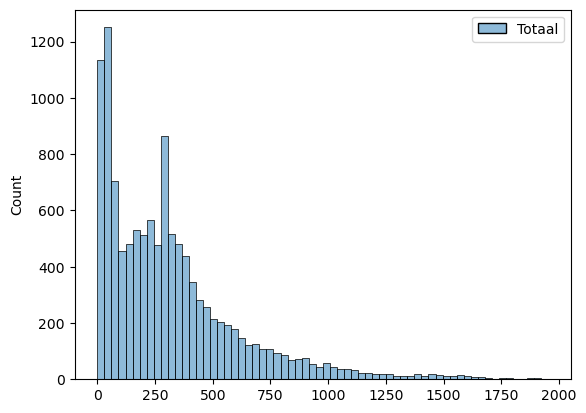

In [151]:
# Plot a histogram of the 'Totaal' column of the 'train_data' DataFrame using seaborn
sns.histplot(train_data.loc[:,['Totaal']])

#### Time series plot

In this section, we're visualizing the sum of bicycle counts at the Coupure Links location, aggregated by month. The resulting plot reveals a clear pattern of seasonality in the data, with bicycle counts fluctuating significantly throughout the year.

Notably, such months as October and March stand out as periods of high bicycle activity. This could be attributed to these months being typical school and work months, where commuting by bicycle is more prevalent. Conversely, months such as December and July show noticeably lower bicycle counts. These months coincide with common holiday periods, where regular commuting patterns are disrupted, leading to a decrease in bicycle usage.

This seasonality is particularly important when considering the month of July, which is the focus of our prediction task. As the data shows, July falls at the lower end of the yearly count spectrum. This presents a risk of overfitting if our model is trained predominantly on data from higher-activity months. Therefore, it's crucial to include features that capture this seasonal variation in our model.

Additionally, the data appears to exhibit autocorrelation, meaning that the bicycle counts at a given time are influenced by the counts at previous times. This is evident in the quasi-stationary distribution that repeats over time, with a slight baseline increase over time. Autocorrelation is a common characteristic of time series data and can be leveraged to improve the predictive performance of our model.

   month_year  month  year  Totaal month_year_dt
2     03-2022      3  2022  251895    2022-03-01
4     04-2022      4  2022  199802    2022-04-01
6     05-2022      5  2022  252478    2022-05-01
8     06-2022      6  2022  229834    2022-06-01
10    07-2022      7  2022  179065    2022-07-01


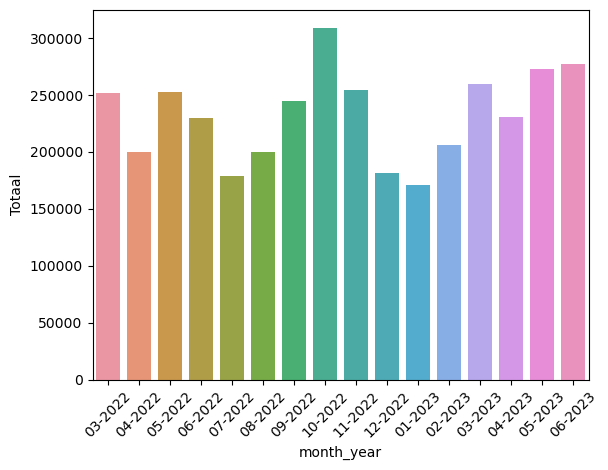

In [152]:
# Group the 'train_data' DataFrame by 'month_year', 'month', and 'year', calculate the sum of the 'Totaal' column for each group, reset the index, and store the result in 'sum_by_month'
sum_by_month = train_data.groupby(['month_year', 'month', 'year']).agg({'Totaal': 'sum'}).reset_index()

# Convert the 'month_year' column of 'sum_by_month' to datetime format and store the result in 'month_year_dt'
sum_by_month['month_year_dt'] = pd.to_datetime(sum_by_month['month_year'], format='%m-%Y')

# Sort 'sum_by_month' by 'month_year_dt' and store the result back in 'sum_by_month'
sum_by_month = sum_by_month.sort_values(by='month_year_dt')

# Print the first 5 rows of 'sum_by_month'
print(sum_by_month.head())

# Create a bar plot of the 'Totaal' column of 'sum_by_month' against the 'month_year' column
sns.barplot(x = "month_year", y = "Totaal", data = sum_by_month)

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Display the plot
%matplotlib inline

#### Heatmap Plot: Correlation Matrix

In this section, we're creating a correlation matrix heatmap to visualize the relationships between all numerical features and the response variable. This is a powerful tool for understanding the interdependencies among multiple variables simultaneously.

The correlation matrix is a square matrix that contains the Pearson correlation coefficients for each pair of variables in our dataset. These coefficients range from -1 to 1, with -1 indicating a perfect negative correlation, 1 indicating a perfect positive correlation, and 0 indicating no correlation.

The heatmap is a graphical representation of this matrix, where the color of each cell corresponds to the correlation coefficient of the corresponding variable pair. This makes it easy to identify highly correlated variables at a glance.

From the heatmap, we observe some degree of multicollinearity, which refers to a situation where two or more variables are highly correlated. While multicollinearity is not inherently problematic, it can pose challenges in certain situations, such as when interpreting the coefficients of a linear regression model.

However, the level of multicollinearity observed here is not overly concerning. It's important to remember that correlation does not imply causation, and a high correlation between two variables does not necessarily mean that one causes the other.

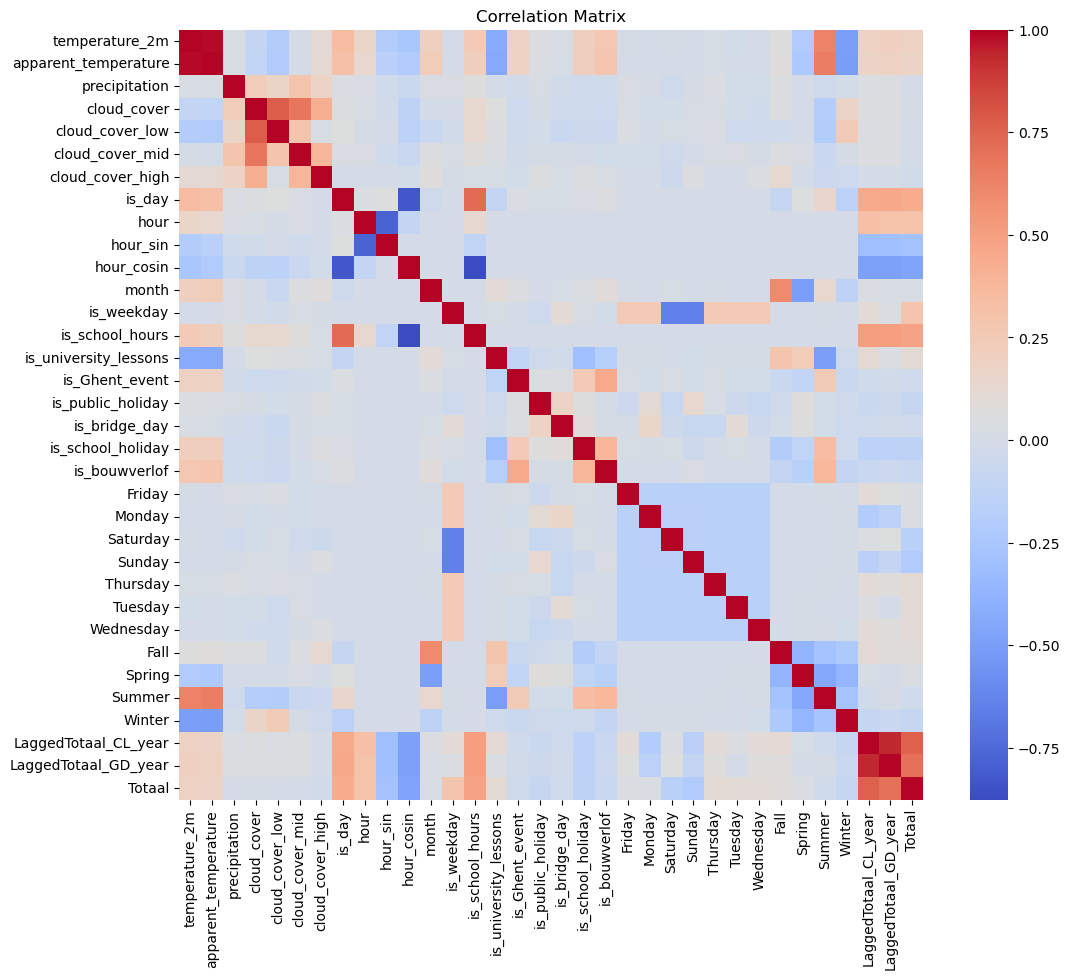

In [153]:
# Calculate the correlation matrix of the numeric features in 'train_data' and store it in 'cormat'
cormat = train_data.loc[:, all_features + ["Totaal"]].corr()

# Create a new figure with a specified size
plt.figure(figsize=(12, 10))

# Create a heatmap of 'cormat' using seaborn
sns.heatmap(cormat, cmap='coolwarm')

# Set the title of the plot to 'Correlation Matrix'
plt.title('Correlation Matrix')

# Display the plot
plt.show()

#### Pairwise Plot: Lagged Bicycle Measurements

The analysis of the lagged counters' distributions reveals a key insight about cycling trends in Ghent: they appear to be largely independent of the specific district. This observation is based on the similarity of the distributions across different lagged counters.

In other words, the patterns of bicycle usage over time do not vary significantly from one district to another. This could suggest that the factors influencing bicycle usage, such as weather conditions, time of year, and day of the week, have a similar impact across all districts.

This finding has important implications for our predictive model. It suggests that we can potentially use the same model to predict bicycle counts in all districts, rather than having to develop separate models for each district. This could greatly simplify our modeling process and make our predictions more consistent and reliable.

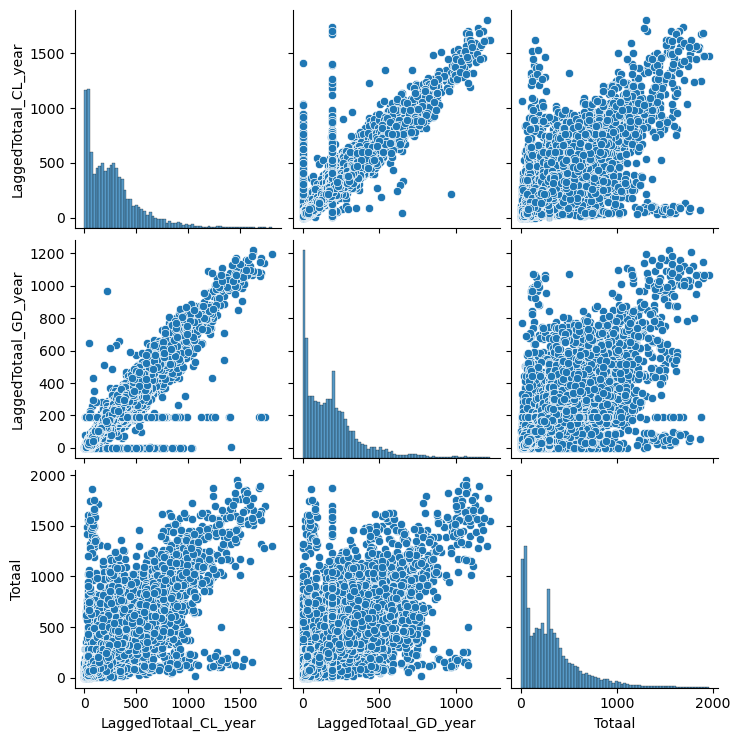

In [154]:
# Define a list of features to plot
plot_features = ['LaggedTotaal_CL_year', 'LaggedTotaal_GD_year']

# Create a pairplot of the features in 'plot_features' and 'Totaal' using seaborn
sns.pairplot(train_data.loc[:,plot_features + ["Totaal"]])

#### Pairwise Plot: Weather and Temporal

In this section, we delve into the relationship between our weather and temporal features and the response variable. Our analysis suggests that these relationships are often non-linear, which has significant implications for our modeling strategy.

For instance, we observe that both low and high temperatures lead to a decrease in the number of cyclists. This suggests a U-shaped relationship between temperature and bicycle counts, where moderate temperatures result in the highest number of cyclists. This pattern could be attributed to the fact that extreme temperatures, whether hot or cold, tend to discourage outdoor activities like cycling.

Interestingly, we also find that these temperature effects are more pronounced during the day than at night. This could be because nighttime cycling activity is generally lower and less sensitive to temperature fluctuations. This observation underscores the importance of considering interaction effects in our model, as the impact of a given feature may depend on the values of other features.

These findings provide a strong motivation for using a non-linear model, such as a decision tree or random forest. These models can capture complex, non-linear relationships and interaction effects, making them well-suited to our data. By choosing a model that aligns with the underlying patterns in our data, we can enhance the accuracy and interpretability of our predictions.

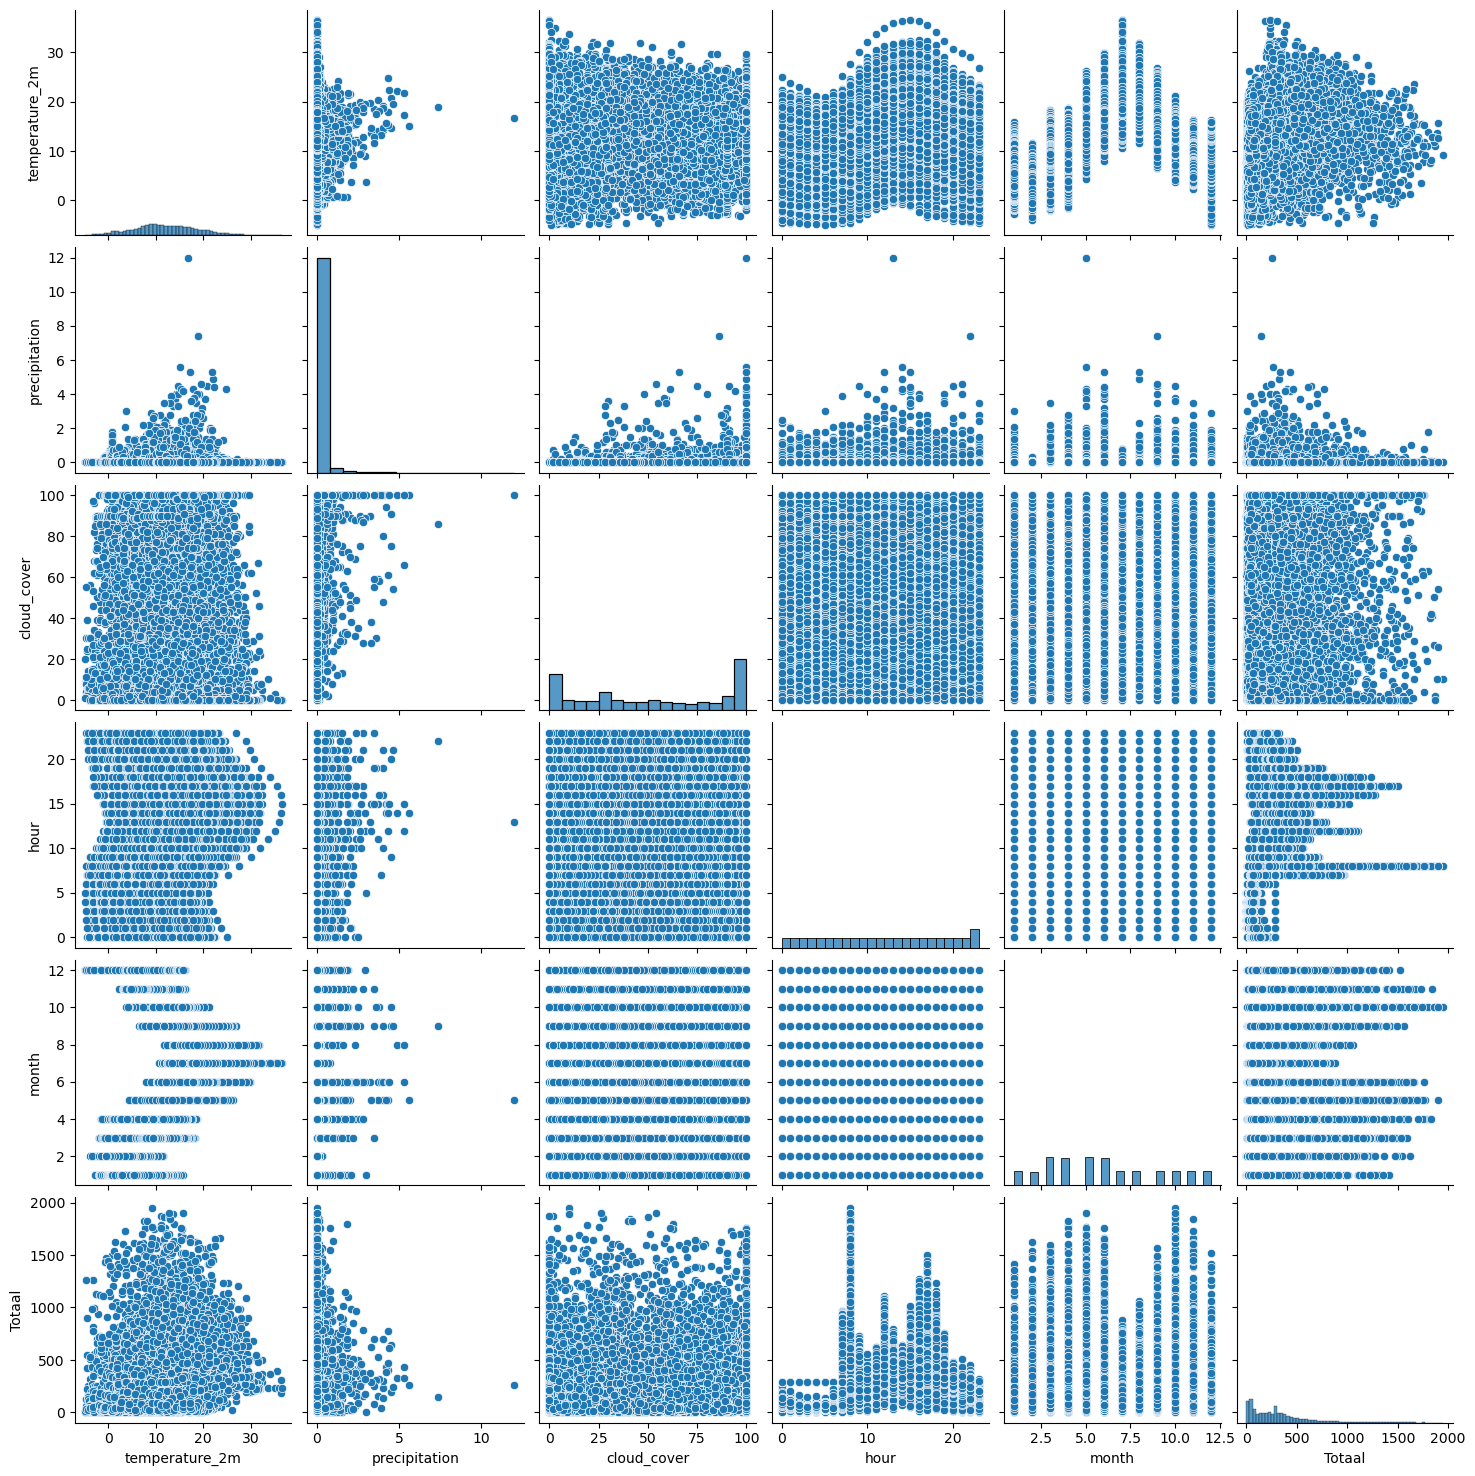

In [155]:
# Define a list of features to plot
plot_features = ['temperature_2m', 'precipitation', 'cloud_cover', 'hour', 'month']

# Create a pairplot of the features in 'plot_features' and 'Totaal' using seaborn
sns.pairplot(train_data.loc[:,plot_features + ["Totaal"]])

#### Pairwise Plot: Booleans

In a similar vein, we can observe that the boolean variables in our dataset appear to influence the maximum values of the response variable, but not the minimum values. This suggests that the presence of certain conditions (represented by the boolean variables) may lead to peak levels of bicycle counts, while the absence of these conditions does not necessarily correspond to the lowest levels of bicycle counts. This asymmetrical influence is an interesting characteristic of our data and could have implications for how we model and interpret the effects of these boolean variables.

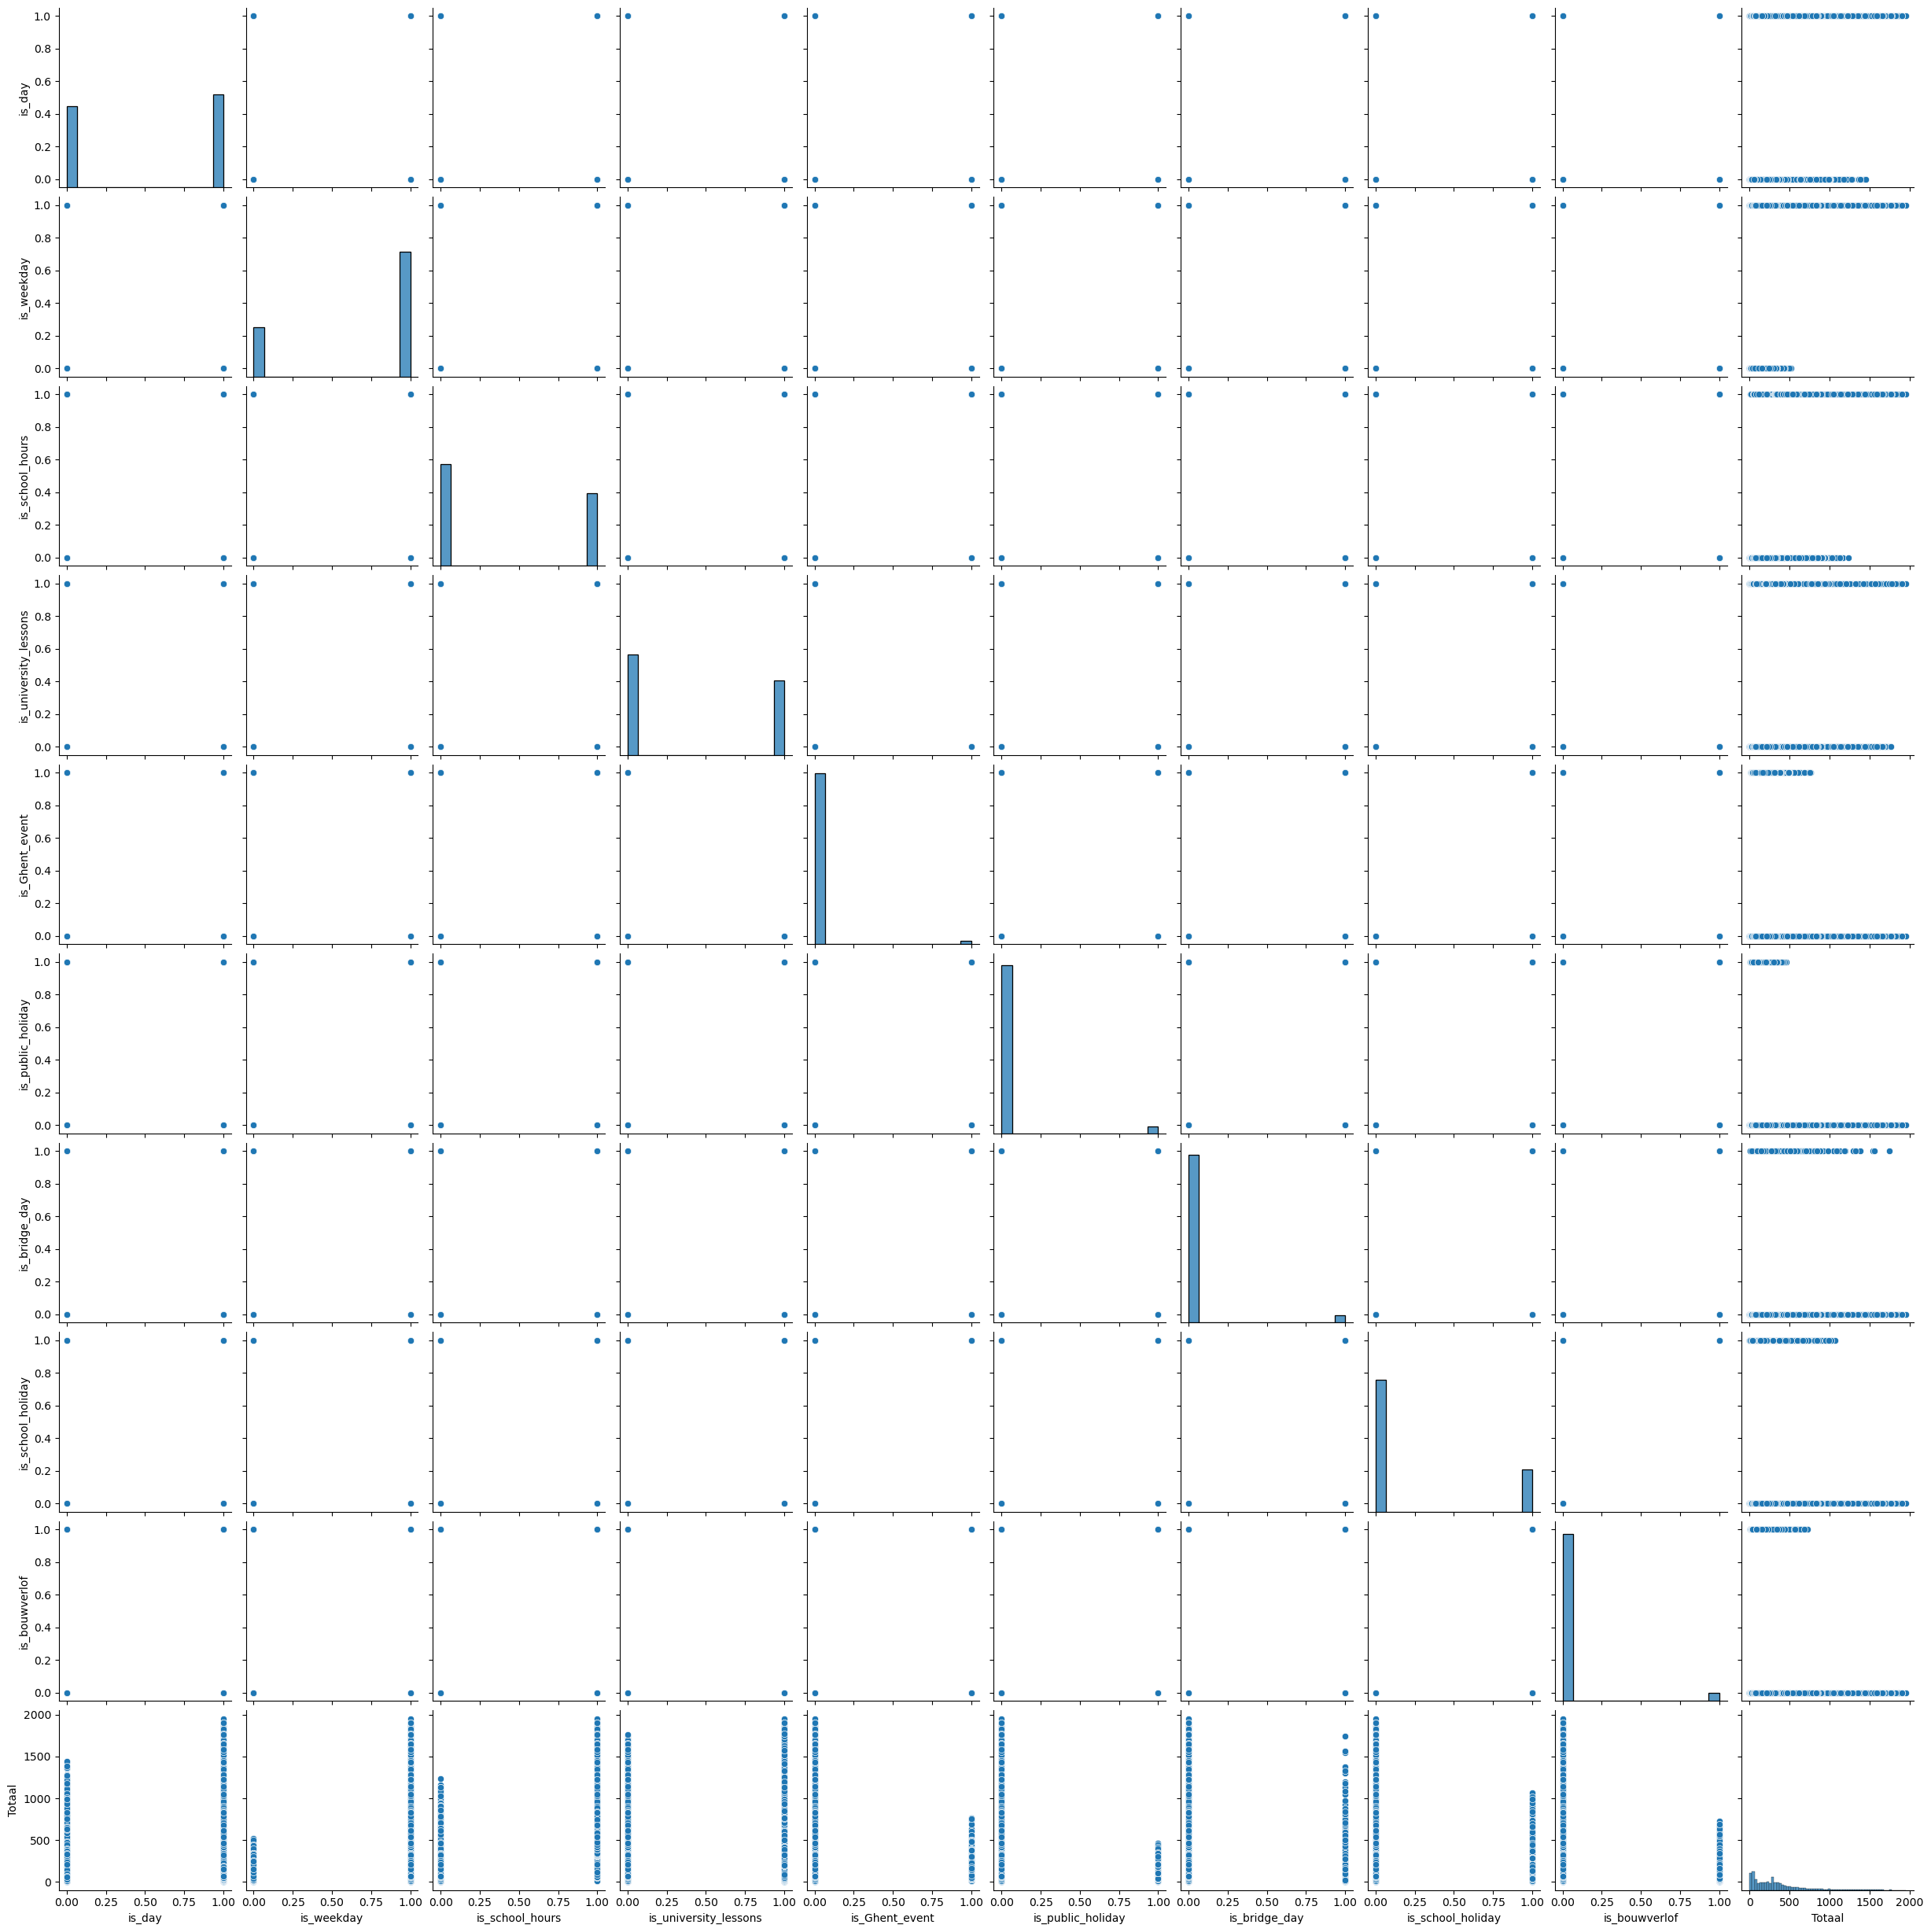

In [156]:
# Define a list of features to plot
plot_features = ['is_day', 'is_weekday', 'is_school_hours', 'is_university_lessons', 'is_Ghent_event', 'is_public_holiday', 'is_bridge_day', 'is_school_holiday', 'is_bouwverlof']

# Create a pairplot of the features in 'plot_features' and 'Totaal' using seaborn
sns.pairplot(train_data.loc[:, plot_features + ["Totaal"]])

## Model Pipeline Construction

#### Training and Test Set

Here we define our training and test sets.

In [157]:
# Select all features from the training data and store it in 'X_train'
X_train = train_data.loc[:, all_features]

# Select all features from the test data and store it in 'X_test'
X_test = test_data.loc[:, all_features]

# Select the 'Totaal' column from the training data and store it in 'y_train'
y_train = train_data["Totaal"]

# Select the 'Totaal' column from the test data and store it in 'y_test'
y_test = gtest_data["Totaal"]

### Model Selection

In the course of this project, a variety of machine learning models were evaluated to identify the most effective approach for predicting bicycle counts. These models spanned several categories, including:

**Linear Models (LM)**
- Linear Regression
- Ridge Regression
- Lasso Regression

Performance ranged from middling to poor in testing. Linear models assume a linear relationship between the predictors and the response variable. If this assumption is violated, as is often the case with complex, real-world data, these models may not perform well. Additionally, linear models can be sensitive to outliers, which can distort the model's predictions. The more linearly correlated features are present, such as those derived from other bike counters, the less these models will tend to struggle.

**Generalized Linear Models (GLM)**
- Poisson Regression
- Negative Binomial Regression
- Tweedie Regression

Despite their theoretical suitability for count data, Generalized Linear Models (GLMs) such as Poisson Regression did not perform as well as expected. This could be due to the data not perfectly following a binomial distribution, possibly as a result of data imputation and the presence of outliers. Moreover, Poisson regression does not mix well with zero-inflation and non-linearity, all unfortunate characteristics of our particular response variable.

While GLMs are flexible and can model different types of response distributions, they can struggle with overdispersion, where the variance is greater than the mean. This is a common issue with count data. Furthermore, GLMs assume that errors are independently distributed, which may not be the case with time series data.

**Decision Trees (DT)**
- Decision Tree Regression

Decision trees can easily overfit the training data, leading to poor generalization to new data. They are also sensitive to small changes in the data, which can result in drastically different trees. Indeed, it was noticed that this model achieved the highest score when predicting for the training set. July, however, is an anomaly when it comes to cycling activity, which makes the risk of overfitting too great to make Decision Trees a safe choice.

**Support Vector Machine (SVM) Regression**

SVMs can be sensitive to the choice of the kernel and the tuning of the hyperparameters. If these are not chosen carefully, the model may not perform well. Additionally, SVMs can struggle with large datasets due to their high computational complexity. In the end, a middling score and one of the longest training times made it so that SVR did not make the cut.

**Gaussian Process Regression**

Gaussian processes are a powerful tool for regression tasks, but they can be computationally intensive, especially for large datasets. In fact, my coimputer crashed numerous times while attempting to train it. They also require careful choice and tuning of the kernel function, which can be challenging.

**Ensemble Methods**
- Random Forest Regression
- Gradient Boosting Regression

In contrast, ensemble methods like Gradient Boosting Regression are able to capture complex, non-linear relationships and interactions between features, making them more robust to various data characteristics. They also have mechanisms to prevent overfitting, such as bagging and boosting, which can improve their generalization performance. Moreover, they sit comfortably between linear models and kernel methods in terms of training time.

After extensive testing and comparison, ensemble methods emerged as the most reliable, with Gradient Boosting Regression delivering the best overall performance. These models excel at capturing complex, non-linear relationships and interactions, which likely contributed to their superior performance.

### Feature Normalization

For normalization of our data, we apply sklearn's `StandardScaler` to normalize our features in the training and test sets. `StandardScaler` standardizes features by removing the mean and scaling to unit variance. This process is crucial for many machine learning algorithms that are sensitive to the scale of the features.

The standard score of a sample x is calculated as follows:

$$
z = (x - u) / s
$$

where:
- `u` is the mean of the training samples
- `s` is the standard deviation of the training samples

The process of centering and scaling is performed independently on each feature. It involves computing the relevant statistics (mean and standard deviation) on the samples in the training set. These statistics are then stored and used to transform later data.

The reason for this normalization process is that many elements used in the objective function of a learning algorithm, such as L1 regularizers (which we will be using in our pipeline for feature selection), assume that all features are centered around zero and have variance in the same order. 

If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function. This could potentially make the estimator unable to learn from other features correctly as expected. Therefore, by standardizing the features, we ensure that all of them contribute equally to the final prediction, leading to a more balanced and accurate model.

### Feature Selection

Ensemble methods inherently assign an importance score to each feature, effectively "weighting" them within the model. This means that less important features will naturally have less influence on the model's predictions. However, to further optimize our model and reduce computational load, we employ a feature selection technique using Lasso Regression Regularization before training our Gradient Boosting Regression model.

Lasso Regression Regularization is a method that can help in feature selection by assigning a penalty to the absolute size of the coefficients of features. This penalty can shrink some of the coefficients to zero, effectively eliminating those features from the model. This is particularly useful when dealing with datasets that have a large number of features, as it can help to prevent overfitting and improve model interpretability.

We implement this feature selection technique using the `SelectFromModel` function in conjunction with the `Lasso` model function, both provided by the sklearn library. The `SelectFromModel` function is a meta-transformer that can be used alongside any estimator that assigns importance to features. In our case, it uses the coefficients from the Lasso model to select the most important features.

By filtering out less important features, we can reduce the dimensionality of our data and decrease the training time of our model. Moreover, this process can often improve the performance of the model by eliminating noise and focusing on the most informative features. In practice, both training time and performance are indeed slightly optimized as a result.

### Training: Best Theoretical Model

For our first model training showcase, we manually fine-tune the hyperparameters to achieve the best possible theoretical performance for our specific test set. It's crucial to emphasize that this approach deviates from standard modeling practices and is not recommended for general use.

Typically, hyperparameters should be determined based on the training set or through cross-validation to ensure the model's ability to generalize well to unseen data. However, in this context, we are customizing the model to our test set to demonstrate the maximum potential performance for this specific dataset, which corresponds to the month of July.

This approach is purely exploratory and is intended to showcase the potential of our model under ideal conditions. It's important to note that while this model may achieve high performance on the leaderboard, it may not perform as well on other datasets due to overfitting. Therefore, for any application beyond this specific competition, it would be more appropriate to use a model trained with hyperparameters obtained from a rigorous cross-validation process. This serves as a reminder of the importance of adhering to best practices in machine learning to ensure robust and reliable model performance.

In [81]:
# Create a pipeline that first standardizes the data, then uses Lasso for feature selection with alpha set to 0.3, and finally applies XGBRegressor with specified parameters
pipeline_BT = make_pipeline(
    StandardScaler(),  # Standardize features by removing the mean and scaling to unit variance
    SelectFromModel(Lasso(alpha = 0.3)),  # Feature selection using Lasso with alpha set to 0.3
    XGBRegressor(  # XGBoost regressor
        max_depth=6,  # Maximum tree depth for base learners
        learning_rate=0.11,  # Boosting learning rate
        n_estimators=100,  # Number of boosted trees to fit
        objective='reg:tweedie',  # Specify the learning task and the corresponding learning objective
    )
)

# Fit the pipeline to the training data
pipeline_BT.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectfrommodel',
                 SelectFromModel(estimator=Lasso(alpha=0.3))),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types...olicy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.11,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, objective='reg:tweedie', ...))])

### Predictions: Best Theoretical Model

Upon evaluating the trained model, we can draw some conclusions from our logarithmic error plots. It appears that our model tends to overestimate counts for July 2023. This overestimation is likely due to the unique characteristics of the summer months, which deviate from the typical patterns observed in other months. In essence, our model seems to be overfitted to the patterns of the regular working months. This is further confirmed by the significantly higher score obtained by the training score compared to the test score.

One potential solution to this issue could be to restrict the training set to only include the months of July and possibly August. This would allow the model to better learn the specific patterns of these summer months and potentially improve its predictions for July 2023. However, while this approach might improve the model's performance for this specific task, it would likely reduce its generalizability to other months.

In the interest of creating a more versatile and reusable model, we have chosen to maintain a broad training range that encompasses all months. This decision is guided by the principle that a good predictive model should not only perform well on the task at hand but also be capable of generalizing to new, unseen data.

Train set R²: 0.9578995748675107
Test set R²: 0.9301528956740222


d:\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


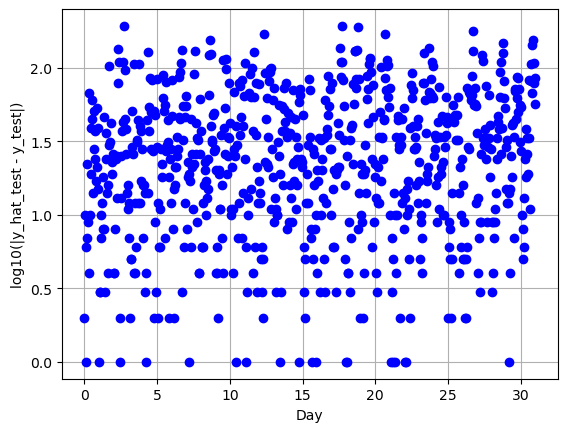

In [82]:
# Use the pipeline to predict the training data, round the predictions to the nearest integer, and store the result in 'y_hat_train'
y_hat_train = np.round(pipeline_BT.predict(X_train))

# Use the pipeline to predict the test data, round the predictions to the nearest integer, and store the result in 'y_hat_test'
y_hat_test = np.round(pipeline_BT.predict(X_test))

# Replace any negative predictions in 'y_hat_train' with 0
y_hat_train[y_hat_train <0] = 0

# Replace any negative predictions in 'y_hat_test' with 0
y_hat_test[y_hat_test <0] = 0

# Calculate the R² score of the pipeline on the training data and store it in 'R_train'
R_train = pipeline_BT.score(X_train, y_train)

# Calculate the R² score of the pipeline on the test data and store it in 'R_test'
R_test = pipeline_BT.score(X_test, y_test)

# Print the R² score of the pipeline on the training data
print('Train set R²: {}'.format(R_train))

# Print the R² score of the pipeline on the test data
print('Test set R²: {}'.format(R_test))

# Save the predictions of the test data using a function 'save_predictions' with the filename "SubmissionP1_BT_LucaVisser", the test data, and the predictions 'y_hat_test'
save_predictions("SubmissionP1_BT_LucaVisser", test_data, y_hat_test)

# Plot the difference between the actual test values and the predicted test values using a function 'plot_diff'
plot_diff(y_test, y_hat_test)

### Analysis: Best Theoretical Model

The feature importances listed here represent the relative importance of each feature in making predictions with the trained XGBoost model. The importance of a feature is calculated based on the number of times a feature is used to split the data across all trees, and the improvement it provides to the model. Here's a brief explanation of the top features:

1. **hour**: This is the most important feature, indicating that the time of day is a significant predictor of bicycle counts. This makes sense as there are likely to be more cyclists during commuting hours.

2. **is_weekday**: This binary feature indicates whether the day is a weekday or not. Its high importance suggests that there are significant differences in bicycle counts between weekdays and weekends.

3. **LaggedTotaal_CL_year**: This feature represents the total count of bicycles from the previous year. Its importance suggests that historical data is a strong predictor of future counts.

4. **hour_cosin**: This is a transformation of the hour feature to capture the cyclical nature of time. Its importance indicates that the time of day, when represented in a cyclical manner, is a significant predictor.

5. **is_school_hours**: This binary feature indicates whether the current time falls within school hours. Its importance suggests that school hours significantly affect bicycle counts, likely due to school-related commuting.

The other features have lower importance scores, indicating that they contribute less to the model's predictions. However, they still provide valuable information that helps the model capture the complexity of the data. For example, features like `is_public_holiday`, `is_school_holiday`, and `is_bouwverlof` (construction holiday) help the model account for special days when bicycle counts may be different from regular days.

In [83]:
# Get the XGBoost model from the pipeline
xgb_model = pipeline_BT.named_steps['xgbregressor']

# Get the feature importance scores
importance_scores = xgb_model.feature_importances_

# Get the feature names from the selector
selected_features = X_train.columns[pipeline_BT.named_steps['selectfrommodel'].get_support()]

# Create a DataFrame of feature names and their corresponding importance scores
feature_importances = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importance_scores
})

# Sort the DataFrame by the importance scores in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Print the feature importances
print(feature_importances)

                  Feature  Importance
8                    hour    0.258377
12             is_weekday    0.123780
28   LaggedTotaal_CL_year    0.107648
10             hour_cosin    0.073612
13        is_school_hours    0.057436
18      is_school_holiday    0.039037
26                 Spring    0.038502
21                 Monday    0.037973
16      is_public_holiday    0.026952
29   LaggedTotaal_GD_year    0.019208
9                hour_sin    0.019185
14  is_university_lessons    0.016927
7                  is_day    0.016917
17          is_bridge_day    0.016378
11                  month    0.014779
20                 Friday    0.013222
25                   Fall    0.012815
23               Thursday    0.011898
22               Saturday    0.011403
19          is_bouwverlof    0.011349
1    apparent_temperature    0.011185
2           precipitation    0.011152
24                Tuesday    0.008754
0          temperature_2m    0.007818
3             cloud_cover    0.006707
5         cl

### Cross-validation

In an ideal scenario, the final model selection should always be guided by cross-validation. This is because, in real-world situations, we don't have access to the actual dataset we want to predict. Hence, the implementation of a cross-validation pipeline, as shown below, is a crucial step in our modeling process. 

Cross-validation involves partitioning the data into subsets, training the model on a subset, and then evaluating it on the remaining subset. This process is repeated multiple times, with different subsets used for training and evaluation each time. The goal is to assess how well the model will generalize to an independent dataset.

Ideally, we would provide an input grid with a wide range of hyperparameters and high resolution. The optimal hyperparameters returned would then be the best approximation for our test set based on the available data.

However, due to computational constraints and the competitive nature of this project, the implementation here is a modest tribute to best practices. In a perfect world, we would explore a broader range of hyperparameters such as maximum tree depth, number of estimators, learning rate, and more, in even smaller increments. But we must work within our hardware limitations.

In [40]:
# Create a pipeline that first standardizes the data and then uses Lasso for feature selection, and store it in 'selector'
selector = make_pipeline(StandardScaler())

# Fit 'selector' to the training data
selector.fit(X_train, y_train)

# Create an instance of the XGBRegressor class and store it in 'model_to_tune'
model_to_tune = XGBRegressor()

# Define a grid of hyperparameters to search over
param_grid = {"max_depth": np.arange(3, 8, 1),
              "learning_rate": np.arange(0.08, 0.12, 0.01),
              "n_estimators": np.arange(100, 110, 5),
              "objective": ["reg:tweedie", "reg:squarederror"],
              "min_child_weight": np.arange(0, 2, 1)
              }

# Use nested k-fold cross-validation to find the best hyperparameters for 'model_to_tune' and store them in 'best_params'
best_params = nested_kfold_cv(model_to_tune, param_grid, selector.transform(X_train), y_train)

The mean score using nested cross-validation is: 0.927 ± 0.004
The best parameters found are: {'learning_rate': 0.10999999999999999, 'max_depth': 7, 'min_child_weight': 0, 'n_estimators': 105, 'objective': 'reg:tweedie'}


### Training: Best Cross-Validated Model

The hyperparameters used in this pipeline are those estimated to be optimal from our nested cross-validation process. Here's why these might be optimal:

1. **max_depth = 7**: This parameter sets the maximum depth of a tree and is used to control over-fitting. The optimal value depends on the interaction of features. A depth of 7 indicates that the model allows fairly complex interactions between features.

2. **learning_rate = 0.11**: This is the step size shrinkage used in the update to prevent overfitting. It shrinks the feature weights to make the boosting process more conservative. A learning rate of 0.11 is a balance between a high learning rate (which might lead to overfitting) and a low learning rate (which might require many trees to model complex interactions).

3. **n_estimators = 105**: This is the number of gradient boosted trees. Too many might lead to overfitting, too few might not capture important patterns. 105 trees might be a good balance for this dataset.

4. **objective = "reg:tweedie"**: This is the loss function to be minimized. The Tweedie regression is used when the target variable is a positive continuous variable, and can be particularly useful for highly skewed target variables.

5. **min_child_weight = 0**: This parameter decides the minimum sum of weights of all observations required in a child. This is similar to min_child_leaf in GBM but not exactly. This refers to the minimum sum of weights of all observations while GBM has min number of observations for the leaf node. The larger, the more conservative the algorithm will be. A value of 0 means there is no minimum limit.

In [84]:
# Create a pipeline that first standardizes the data, and finally applies XGBRegressor with the best hyperparameters found by nested k-fold cross-validation, and store it in 'pipeline'
pipeline_CV = make_pipeline(StandardScaler(), XGBRegressor(max_depth = 7, 
                                                        learning_rate = 0.11, 
                                                        n_estimators = 105, 
                                                        objective = "reg:tweedie", 
                                                        min_child_weight = 0))

# Fit the pipeline to the training data
pipeline_CV.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.11,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None, min_child_weight=0,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=105,
                              n_jobs=None, num_parallel_tree=None,
                              objective='reg:tweedie', ...))])

### Predictions: Best Cross-Validated Model

THESE ARE THE PREDICTIONS USED FOR THE FINAL LEADERBOARD SCORE!

Train set R²: 0.9777840209664468
Test set R²: 0.9243848689534897


d:\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


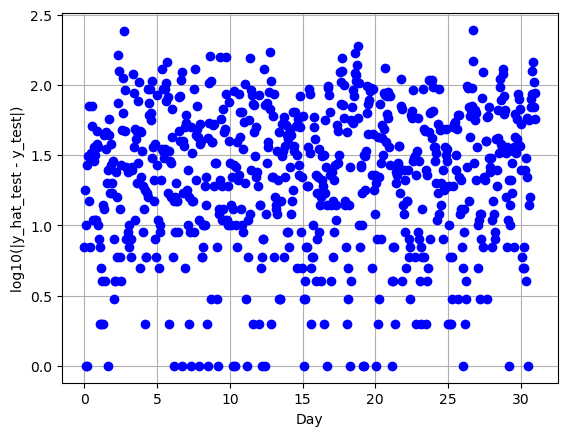

In [85]:
# Use the pipeline to predict the training data, round the predictions to the nearest integer, and store the result in 'y_hat_train'
y_hat_train = np.round(pipeline_CV.predict(X_train))

# Use the pipeline to predict the test data, round the predictions to the nearest integer, and store the result in 'y_hat_test'
y_hat_test = np.round(pipeline_CV.predict(X_test))

# Replace any negative predictions in 'y_hat_train' with 0
y_hat_train[y_hat_train <0] = 0

# Replace any negative predictions in 'y_hat_test' with 0
y_hat_test[y_hat_test <0] = 0

# Calculate the R² score of the pipeline on the training data and store it in 'R_train'
R_train = pipeline_CV.score(X_train, y_train)

# Calculate the R² score of the pipeline on the test data and store it in 'R_test'
R_test = pipeline_CV.score(X_test, y_test)

# Print the R² score of the pipeline on the training data
print('Train set R²: {}'.format(R_train))

# Print the R² score of the pipeline on the test data
print('Test set R²: {}'.format(R_test))

# Save the predictions of the test data using a function 'save_predictions' with the filename "SubmissionP1_CV_LucaVisser", the test data, and the predictions 'y_hat_test'
save_predictions("SubmissionP1_CV_LucaVisser", test_data, y_hat_test)

# Plot the difference between the actual test values and the predicted test values using a function 'plot_diff'
plot_diff(y_test, y_hat_test)

### Analysis: Best Cross-Validated Model

In [86]:
# Get the XGBoost model from the pipeline
xgb_model = pipeline_CV.named_steps['xgbregressor']

# Get the feature importance scores
importance_scores = xgb_model.feature_importances_

# Get the feature names from the selector
selected_features = X_train.columns

# Create a DataFrame of feature names and their corresponding importance scores
feature_importances = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importance_scores
})

# Sort the DataFrame by the importance scores in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Print the feature importances
print(feature_importances)

                  Feature  Importance
8                    hour    0.235321
12             is_weekday    0.158307
31   LaggedTotaal_CL_year    0.083108
13        is_school_hours    0.069053
10             hour_cosin    0.067714
18      is_school_holiday    0.040215
28                 Spring    0.038106
21                 Monday    0.037481
16      is_public_holiday    0.023133
30                 Winter    0.021334
9                hour_sin    0.020801
14  is_university_lessons    0.015688
32   LaggedTotaal_GD_year    0.015566
17          is_bridge_day    0.014875
26              Wednesday    0.013962
20                 Friday    0.011786
7                  is_day    0.011349
19          is_bouwverlof    0.011031
27                   Fall    0.010857
22               Saturday    0.010775
11                  month    0.009957
25                Tuesday    0.009377
1    apparent_temperature    0.009313
23                 Sunday    0.009150
2           precipitation    0.008709
15         i